# PREDICTING HOSPITAL LENGTH OF STAY (MIMICIII DATA)

## Second code using 4 - class classification model with Long intervals in LOS

In [ ]:
#importing the necessary libraries
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification

In [2]:
# configure settings for visualizations
sns.set_style('darkgrid')  
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']= (8,6)
plt.rcParams['figure.facecolor']= 'white'

In [3]:
conn = psycopg2.connect(                      #establishing connection to database
           host='localhost',   #database host name
           database = 'mimic',  # database name
           user = 'postgres',   # database user name
           port = '5432',      #database port number
           password='Ram739ad') # database password
           
cur = conn.cursor()              # create a cursor object for executing queries


## Importing Mimiciii data from database

In [4]:
#selecting combined colums from admission table and patients table and calculating age and length of stay from database
query = """
SELECT 
    round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 0) 
    as age, 
  round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 0) as los,
  p.subject_id,a.admission_type,a.admission_location,a.discharge_location,a.insurance,a.language,a.religion,a.marital_status,
  p.gender,a.ethnicity,a.diagnosis,a.edregtime,a.edouttime,a.hospital_expire_flag,a.has_chartevents_data
FROM mimiciii.admissions a
INNER JOIN mimiciii.patients p ON a.subject_id = p.subject_id 
"""
combineddf = pd.read_sql_query(query,conn)#execute the query and store the result in a pandas DataFrame
combineddf

,age,los,subject_id,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,gender,ethnicity,diagnosis,edregtime,edouttime,hospital_expire_flag,has_chartevents_data
0,65.0,1.0,22,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,F,WHITE,BENZODIAZEPINE OVERDOSE,2196-04-09 10:06:00,2196-04-09 13:24:00,0,1
1,71.0,5.0,23,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,M,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,NaT,NaT,0,1
2,75.0,7.0,23,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,M,WHITE,BRAIN MASS,NaT,NaT,0,1
3,39.0,3.0,24,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,M,WHITE,INTERIOR MYOCARDIAL INFARCTION,NaT,NaT,0,1
4,59.0,4.0,25,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,M,WHITE,ACUTE CORONARY SYNDROME,2160-11-02 01:01:00,2160-11-02 04:27:00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,19.0,3.0,98800,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,F,WHITE,TRAUMA,2131-03-30 19:44:00,2131-03-30 22:41:00,0,1
58972,83.0,1.0,98802,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,F,WHITE,SAH,2151-03-05 17:23:00,2151-03-05 21:06:00,1,1
58973,43.0,8.0,98805,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,M,WHITE,RENAL CANCER/SDA,NaT,NaT,0,1
58974,61.0,41.0,98813,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,F,WHITE,S/P FALL,2128-11-10 23:48:00,2128-11-11 03:16:00,0,0


In [7]:
alldata_df = combineddf.copy()#making a copy of the data for future use

## Preliminary exploration of the dataset
### Length of Stay

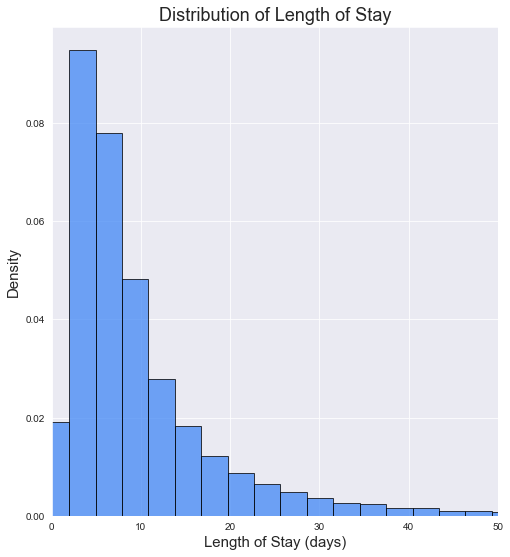

<Figure size 432x288 with 0 Axes>

In [5]:


import matplotlib.pyplot as plt

# create histogram with modified settings
combineddf.los.plot.hist(bins=100, figsize=(8,9), color='#4287f5', density=True, alpha=0.75, edgecolor='black')

# set title, labels, and axis limits
plt.title('Distribution of Length of Stay',fontsize =18)
plt.xlabel('Length of Stay (days)',fontsize = 15)
plt.ylabel('Density',fontsize=15)
plt.xlim(0, 50)

# show plot
plt.show()

# save plot as PNG file
plt.savefig('LOS_distribution.png')


Generally, the distribution of LOS for the MIMIC-III dataset is positively skewed, with a relatively short median and a long tail of patients with high LOS. This is consistent with the nature of the ICU environment, where patients with severe or complex medical conditions may require prolonged hospitalization and intensive care. Further statiscal test and analysis will be done to investigate the reason for the skewness

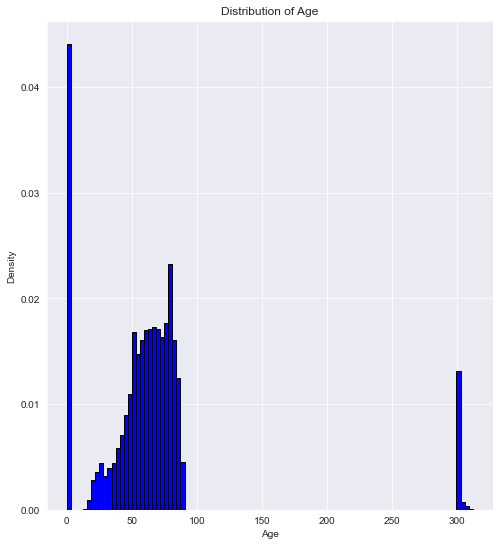

In [8]:
#creating a histogram plot for whole set of data including newborns

# plotting histogram plot and adjusting figure size, 
alldata_df.age.plot.hist(bins =100,figsize = (8,9),density = True,color='b',edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

The distribution of patient ages in the database shows a roughly normal distribution of patient ages, with a peak in the 0 year old age. Ages are also spread along the ranges from 16 to 80 approximately which suggests that many patients in this age range are most admitted in the hospital, also a peak at the age 300 means that ages 89 and above have been shifted which means that a large number of patients in the MIMIC-III database are elderly, which is consistent with the fact that the database contains data from a tertiary care hospital where critically ill patients are often elderly. 

We will take age into account as a potential confounding factor, or for identifying trends or patterns in the data that may be specific to certain age groups.

Pediatric patients, or those under the age of 16, require specialized care and may have different clinical characteristics and outcomes compared to adult patients. In addition, the regulations regarding the use of pediatric data can be more stringent than those for adult data, which can make it more difficult to work with pediatric data from MIMIC-III.

Therefore, in order to avoid potential confounding factors and ensure the data is appropriate for the research question being investigated, we will exclude pediatric patients and focus on analyzing data from adult patients age 16 and over

## New data with with ICD9 codes and excluding younger patients

In [9]:
#selecting combined colums from admission table and patients table and diagnosis_icd and calculating age and length of stay from database
query ="""
SELECT 
  CASE 
    WHEN round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 0) >= 89 
    THEN 89 
    ELSE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 0) 
  END as age, 
  round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 0) as los,
  p.subject_id,a.hadm_id,a.admission_type,a.admission_location,a.discharge_location,a.insurance,a.language,a.religion,a.marital_status,
  p.gender,a.ethnicity,a.diagnosis,a.edregtime,a.edouttime,d.icd9_code,a.hospital_expire_flag,a.has_chartevents_data,
  CASE 
    WHEN d.icd9_code BETWEEN '001' AND '139' THEN 'Infectious and Parasitic Diseases'
    WHEN d.icd9_code BETWEEN '140' AND '239' THEN 'Neoplasms'
    WHEN d.icd9_code BETWEEN '240' AND '279' THEN 'Endocrine, Nutritional, and Metabolic Diseases and Immunity Disorders'
    WHEN d.icd9_code BETWEEN '280' AND '289' THEN 'Diseases of the Blood and Blood-forming Organs'
    WHEN d.icd9_code BETWEEN '290' AND '319' THEN 'Mental Disorders'
    WHEN d.icd9_code BETWEEN '320' AND '389' THEN 'Diseases of the Nervous System and Sense Organs'
    WHEN d.icd9_code BETWEEN '390' AND '459' THEN 'Diseases of the Circulatory System'
    WHEN d.icd9_code BETWEEN '460' AND '519' THEN 'Diseases of the Respiratory System'
    WHEN d.icd9_code BETWEEN '520' AND '579' THEN 'Diseases of the Digestive System'
    WHEN d.icd9_code BETWEEN '580' AND '629' THEN 'Diseases of the Genitourinary System'
    WHEN d.icd9_code BETWEEN '630' AND '679' THEN 'Complications of Pregnancy, Childbirth, and the Puerperium'
    WHEN d.icd9_code BETWEEN '680' AND '709' THEN 'Diseases of the Skin and Subcutaneous Tissue'
    WHEN d.icd9_code BETWEEN '710' AND '739' THEN 'Diseases of the Musculoskeletal System and Connective Tissue'
    WHEN d.icd9_code BETWEEN '740' AND '759' THEN 'Congenital Anomalies'
    WHEN d.icd9_code BETWEEN '760' AND '779' THEN 'Certain Conditions originating in the Perinatal Period'
    WHEN d.icd9_code BETWEEN '780' AND '799' THEN 'Symptoms, Signs, and Ill-defined Conditions'
    WHEN d.icd9_code BETWEEN '800' AND '999' THEN 'Injury and Poisoning'
    ELSE 'E & V Group'
  END as ccs_group
FROM mimiciii.admissions a
INNER JOIN mimiciii.patients p ON a.subject_id = p.subject_id
INNER JOIN  mimiciii.diagnoses_icd d ON p.subject_id = d.subject_id
WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 2) >= 16
"""

combineddf = pd.read_sql_query(query,conn)
#combineddf.head()


query = """
SELECT hadm_id, COUNT(icd9_code) as num_comorbidities
FROM mimiciii.diagnoses_icd
GROUP BY hadm_id
"""

comorbiditiesdf = pd.read_sql_query(query, conn)
combineddf = pd.merge(combineddf, comorbiditiesdf, on='hadm_id')#execute the query and store the result in a pandas DataFrame
combineddf.head()

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,language,religion,...,gender,ethnicity,diagnosis,edregtime,edouttime,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,E9317,0,1,E & V Group,9
1,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,042,0,1,Infectious and Parasitic Diseases,9
2,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,1363,0,1,Infectious and Parasitic Diseases,9
3,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,7994,0,1,E & V Group,9
4,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,2763,0,1,"Endocrine, Nutritional, and Metabolic Diseases...",9


In [55]:
combineddf['num_comorbidities'].unique() #checking unique values in comorbidities column

array([11, 27, 20, 14,  6,  9, 15, 17, 13,  8, 29, 18, 12, 16, 25, 28, 19,
       24,  1,  5,  4,  3, 21,  2,  7, 10, 22, 26, 30, 23,  0, 39, 31, 32,
       34, 33, 38, 35, 36, 37], dtype=int64)

## Data Cleaning and Exploration

In [10]:
combineddf.shape ##checking the shape of the dataset

(1325737, 21)

In [11]:
combineddf.duplicated().sum() ## checking for total number of duplicate values in the data

348412

In [12]:
combineddf = combineddf.drop_duplicates(subset=['subject_id'])
combineddf # deleting duplicates values from the dataset

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,language,religion,...,gender,ethnicity,diagnosis,edregtime,edouttime,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-15 13:10:00,2191-03-16 01:10:00,E9317,0,1,E & V Group,9
9,66.0,16.0,6,107064,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,...,F,WHITE,CHRONIC RENAL FAILURE/SDA,NaT,NaT,40391,0,1,Diseases of the Circulatory System,8
17,42.0,5.0,9,150750,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,None,UNOBTAINABLE,...,M,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,2149-11-09 11:13:00,2149-11-09 13:18:00,431,1,1,Diseases of the Circulatory System,6
23,50.0,26.0,11,194540,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,None,OTHER,...,F,WHITE,BRAIN MASS,2178-04-15 20:46:00,2178-04-16 06:53:00,1913,0,1,Neoplasms,1
24,72.0,13.0,12,112213,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,None,JEWISH,...,M,WHITE,PANCREATIC CANCER/SDA,NaT,NaT,1570,1,1,Neoplasms,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325635,83.0,14.0,97164,109302,EMERGENCY,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,Medicare,ENGL,CATHOLIC,...,F,WHITE,CELLULITIS,2134-11-26 12:48:00,2134-11-26 18:20:00,6826,0,1,Diseases of the Skin and Subcutaneous Tissue,9
1325644,79.0,5.0,97484,172304,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,PROTESTANT QUAKER,...,F,WHITE,LEFT BRAIN TUMOR/SDA,NaT,NaT,20280,0,1,Neoplasms,6
1325650,67.0,8.0,97488,161999,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,...,M,WHITE,STROKE;TELEMETRY,2128-08-27 13:12:00,2128-08-27 16:18:00,566,1,1,Diseases of the Digestive System,24
1325720,32.0,2.0,97492,189314,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,NOT SPECIFIED,...,F,WHITE,STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,2158-07-31 20:11:00,2158-08-01 00:02:00,34680,0,1,Diseases of the Nervous System and Sense Organs,8


The data has 1325737 rows and 18 columns, which is very large and could be that since a patient was admitted more than ones there could be duplicates in the dataset. we will handle that by droping all duplicates, however patients may be admitted more than once with different diagnosis, we will check the number of cormobidities.

In [13]:
combineddf.dtypes ##checking data types 

age                            float64
los                            float64
subject_id                       int64
hadm_id                          int64
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
religion                        object
marital_status                  object
gender                          object
ethnicity                       object
diagnosis                       object
edregtime               datetime64[ns]
edouttime               datetime64[ns]
icd9_code                       object
hospital_expire_flag             int64
has_chartevents_data             int64
ccs_group                       object
num_comorbidities                int64
dtype: object

The data contains 20 columns out of which 11 have strings data types, two are float, and 4 are interger data type

In [15]:
combineddf.isnull().sum() ##checking for total missing values

age                         0
los                         0
subject_id                  0
hadm_id                     0
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
language                13782
religion                  425
marital_status           2222
gender                      0
ethnicity                   0
diagnosis                   6
edregtime               15800
edouttime               15800
icd9_code                  20
hospital_expire_flag        0
has_chartevents_data        0
ccs_group                   0
num_comorbidities           0
dtype: int64

Language, edregtime, edouttime contains very large missing data, we will consider dropping these columns to simplify our analysis and reduce the amount of data.

In [16]:
combineddf = combineddf.drop(['language', 'edregtime', 'edouttime'], axis=1) ### dropping language, edregtime and edouttime

In [17]:
# Fill missing icd9_code values with the most common code
most_common_code = combineddf['icd9_code'].mode()[0]
combineddf['icd9_code'] = combineddf['icd9_code'].fillna(most_common_code)


In [18]:
combineddf.duplicated().sum() ## checking for total number of duplicate values in the data

0

In [19]:
comobiditydf = combineddf.copy() ## copying the data into a different variable before dropping duplicate values
comobiditydf.head()

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,religion,marital_status,gender,ethnicity,diagnosis,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,PROTESTANT QUAKER,SINGLE,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",E9317,0,1,E & V Group,9
9,66.0,16.0,6,107064,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NOT SPECIFIED,MARRIED,F,WHITE,CHRONIC RENAL FAILURE/SDA,40391,0,1,Diseases of the Circulatory System,8
17,42.0,5.0,9,150750,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,None,M,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,431,1,1,Diseases of the Circulatory System,6
23,50.0,26.0,11,194540,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,MARRIED,F,WHITE,BRAIN MASS,1913,0,1,Neoplasms,1
24,72.0,13.0,12,112213,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,JEWISH,MARRIED,M,WHITE,PANCREATIC CANCER/SDA,1570,1,1,Neoplasms,9


In [32]:
##grouping and calulating the median length of stay by number of comorbidities
median_los = comobiditydf.groupby('num_comorbidities')['los'].median()
comobiditydf['median_los_comorbidities'] = comobiditydf['num_comorbidities'].map(median_los)
comobiditydf.head()

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,religion,marital_status,gender,ethnicity,diagnosis,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities,median_los_comorbidities
0,25.0,7.0,109,124398,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,NOT SPECIFIED,SINGLE,F,BLACK/AFRICAN AMERICAN,HYPERTENSION,40301,0,1,Diseases of the Circulatory System,11,6.0
18360,42.0,15.0,68,108329,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,PROTESTANT QUAKER,SINGLE,F,BLACK/AFRICAN AMERICAN,WEAKNESS,4254,0,1,Diseases of the Circulatory System,11,6.0
18408,37.0,5.0,71,111944,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Government,NOT SPECIFIED,SINGLE,F,ASIAN,OVERDOSE,9695,0,1,Injury and Poisoning,6,5.0
18414,58.0,4.0,73,194730,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,CATHOLIC,MARRIED,F,WHITE,ACUTE MYOCARDIAL INFARCTION,41001,0,1,Diseases of the Circulatory System,8,6.0
18422,77.0,6.0,75,112086,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,F,WHITE,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT/SDA,4241,0,1,Diseases of the Circulatory System,12,7.0


In [20]:
comobiditydf = comobiditydf.drop_duplicates(subset=['hadm_id']) # droping duplicate values from hadm_id column

In [21]:
comobiditydf['subject_id'].duplicated().sum() # check for duplicate value

0

In [22]:
comobiditydf.shape ## checking the shape after dropping duplicates

(38637, 18)

The size of the data has dropped significantly to 38,637 which means that there were a lot of patients who were admitted more than once

In [23]:
comobiditydf.duplicated().sum() ## checking duplicates again

0

In [24]:
comobiditydf.isnull().sum()

age                        0
los                        0
subject_id                 0
hadm_id                    0
admission_type             0
admission_location         0
discharge_location         0
insurance                  0
religion                 425
marital_status          2222
gender                     0
ethnicity                  0
diagnosis                  6
icd9_code                  0
hospital_expire_flag       0
has_chartevents_data       0
ccs_group                  0
num_comorbidities          0
dtype: int64

Religion, marital_status, diagnosis and icd9_code contains some missing data however since the number of missing values is not significant we threat this by filling them with the mode

In [25]:
## filling the missing columns with the modes
cols_to_impute = ['icd9_code', 'marital_status', 'diagnosis', 'religion']
for col in cols_to_impute:
    most_common_value = comobiditydf[col].mode()[0]
    comobiditydf[col] = comobiditydf[col].fillna(most_common_value)


In [26]:
comobiditydf.isnull().sum() ## checking for missing value again

age                     0
los                     0
subject_id              0
hadm_id                 0
admission_type          0
admission_location      0
discharge_location      0
insurance               0
religion                0
marital_status          0
gender                  0
ethnicity               0
diagnosis               0
icd9_code               0
hospital_expire_flag    0
has_chartevents_data    0
ccs_group               0
num_comorbidities       0
dtype: int64

## Distribution of Length of Stay

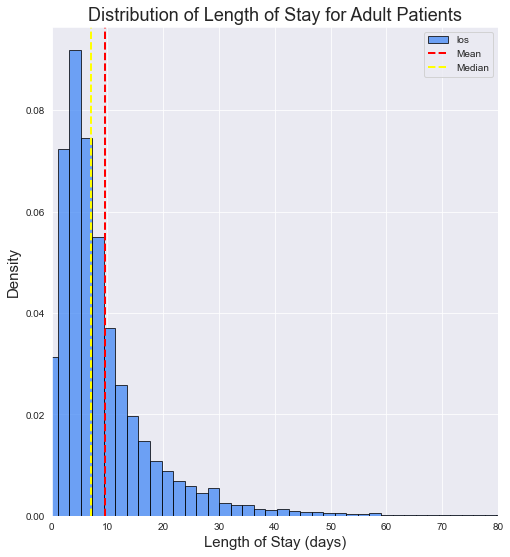

In [27]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Calculate the statistical summary of the los column
stats_los = comobiditydf['los'].describe()




# Create a histogram of the los column
comobiditydf.los.plot.hist(bins=100, figsize=(8,9), color='#4287f5', alpha=0.75, edgecolor='black',density=True)
plt.xlim(0,80)
plt.title('Distribution of Length of Stay for Adult Patients',fontsize =18)
plt.xlabel('Length of Stay (days)',fontsize = 15)
plt.ylabel('Density',fontsize = 15)

# Calculate the mean and median values of the los column
mean_los = comobiditydf.los.mean()
median_los = comobiditydf.los.median()

# Add vertical dashed lines for the mean and median values
plt.axvline(mean_los, color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(median_los, color='yellow', linestyle='--', linewidth=2, label='Median')

# Add a legend to the plot
plt.legend()

# Display the figure
plt.show()


The standard deviation is quite large compared to the mean, indicating that the length of stay varies widely across the dataset.
The shortest recorded length of stay is -1, It's likely that this negative value represent some kind of error or missing data. further investigation will be done to acertain this.
25% of patients have a length of stay of 4 days or less.
Half of the patients have a length of stay of 7 days or less, and half have a length of stay of more than 7 days.
75% of patients have a length of stay of 12 days or less.
This is the longest recorded length of stay in the data is 295 days.

In summary, the average length of stay for patients in the dataset is almost 10 days, but there is a lot of variation around this value. The length of stay can range from negative values (which likely represent missing or erroneous data) to as much as 295 days. About 25% of patients are discharged in 4



The plot shows that the distribution of LOS is skewed to the right, indicating that the majority of patients have a shorter stay in the hospital, and there are fewer patients with longer stays.
The plot also shows that the highest frequency of patients has a LOS of approximately 3-5 days, with a gradual decrease in frequency as the LOS increases. Additionally, there seems to be a small bump in the frequency around 20 days, which could indicate a specific pattern or trend in the data. The plot is truncated at 120 days to focus on the majority of patients and not to show outliers with very long LOS. 

## Distribution of Age

count    58976.000000
mean        64.431684
std         57.199716
min          0.000000
25%         43.000000
50%         62.000000
75%         76.000000
max        312.000000
Name: age, dtype: float64


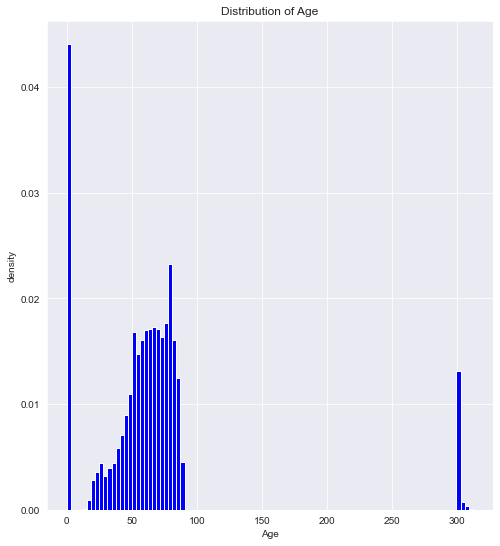

In [28]:
stats_age= alldata_df['age'].describe()
print(stats_age)

alldata_df.age.plot.hist(bins = 100,figsize = (8,9), density = True,color='b')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('density')
plt.show()

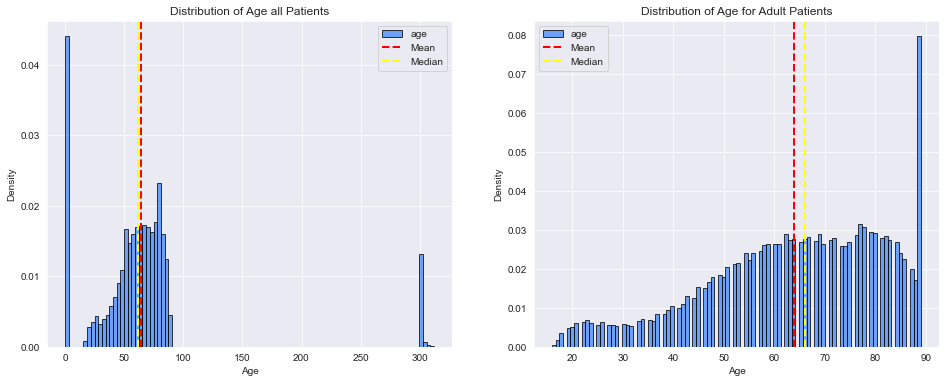

In [29]:



import numpy as np

# calculate mean and median of age for combineddf and comobiditydf
alldata_df_mean = alldata_df.age.mean()
alldata_df_median = alldata_df.age.median()
comobiditydf_mean = comobiditydf.age.mean()
comobiditydf_median = comobiditydf.age.median()

# create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the histogram of age for combineddf on the first subplot
alldata_df.age.plot.hist(bins=100, density=True, ax=axs[0], color='#4287f5', alpha=0.75, edgecolor='black')
axs[0].set_title('Distribution of Age all Patients')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Density')

# add mean and median lines to first subplot
axs[0].axvline(alldata_df_mean, color='red', linestyle='--', linewidth=2, label='Mean')
axs[0].axvline(alldata_df_median, color='yellow', linestyle='--', linewidth=2, label='Median')
axs[0].legend()

# plot the histogram of age for comobiditydf on the second subplot
comobiditydf.age.plot.hist(bins=100, density=True, color='#4287f5', alpha=0.75, edgecolor='black', ax=axs[1])
axs[1].set_title('Distribution of Age for Adult Patients')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Density')

# add mean and median lines to second subplot
axs[1].axvline(comobiditydf_mean, color='red', linestyle='--', linewidth=2, label='Mean')
axs[1].axvline(comobiditydf_median, color='yellow', linestyle='--', linewidth=2, label='Median')
axs[1].legend()

# display the plot
plt.show()


The average age of patients is about 63 years, with a standard deviation of about 17 years, indicating that there is some variability in ages. The youngest patient in the dataset is 16 years old, which is the minimum age requirement to be included in the dataset. The median age is 66 years, indicating that half of the patients are older than this age and half are younger. The interquartile range (IQR) of ages is from 52 to 78 years, indicating that the middle 50% of patients are in this age range. The oldest patient in the dataset is 89 years old, which is the maximum age of patients in the dataset.

## Age and Length of Stay

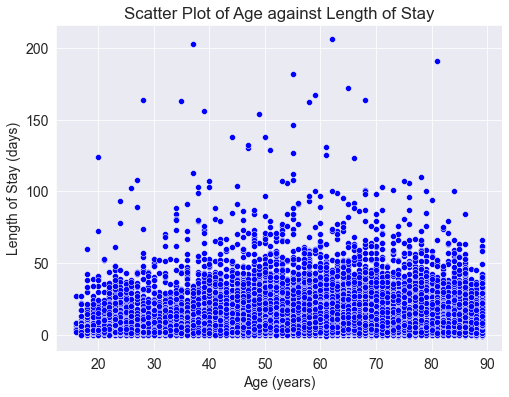

In [30]:
#visualise the distribution of age and loS, with a scatterplot
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})
sns.scatterplot(x=comobiditydf['age'],y=comobiditydf['los'],data=comobiditydf, color='blue', marker='o')
plt.title('Scatter Plot of Age against Length of Stay')
plt.xlabel('Age (years)')
plt.ylabel('Length of Stay (days)')
plt.grid(True)


The scatter plot suggests that there is a weak positive correlation between age and length of stay. This means that as the age of the patient increases, the length of stay in the hospital tends to increase slightly. However, the relationship is not very strong, as there are many points scattered throughout the plot with varying ages and lengths of stay.

It is also worth noting that there are some outliers in the plot, which represent patients who have very long lengths of stay in the hospital. These outliers could be the result of severe medical conditions or complications that require extended hospitalization. Additionally, there is a cluster of points in the bottom left corner of the plot, which represent younger patients with relatively short lengths of stay.

## Age categories and length of Stay

In [31]:
comobiditiesdf = comobiditydf.copy() ## making a copy of the datafram 
comobiditiesdf.isnull().sum()

age                     0
los                     0
subject_id              0
hadm_id                 0
admission_type          0
admission_location      0
discharge_location      0
insurance               0
religion                0
marital_status          0
gender                  0
ethnicity               0
diagnosis               0
icd9_code               0
hospital_expire_flag    0
has_chartevents_data    0
ccs_group               0
num_comorbidities       0
dtype: int64

In [32]:
comobiditiesdf.head()

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,religion,marital_status,gender,ethnicity,diagnosis,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,PROTESTANT QUAKER,SINGLE,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",E9317,0,1,E & V Group,9
9,66.0,16.0,6,107064,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NOT SPECIFIED,MARRIED,F,WHITE,CHRONIC RENAL FAILURE/SDA,40391,0,1,Diseases of the Circulatory System,8
17,42.0,5.0,9,150750,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,MARRIED,M,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,431,1,1,Diseases of the Circulatory System,6
23,50.0,26.0,11,194540,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,MARRIED,F,WHITE,BRAIN MASS,1913,0,1,Neoplasms,1
24,72.0,13.0,12,112213,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,JEWISH,MARRIED,M,WHITE,PANCREATIC CANCER/SDA,1570,1,1,Neoplasms,9


In [33]:
# Define the bin edges for the age groups
bin_edges = [16, 40, 64, 89]

# Use the cut function to assign each age to a category
age_labels = ['young', 'mid-age', 'old']
comobiditiesdf['age_group'] = pd.cut(comobiditiesdf['age'], bins=bin_edges, labels=age_labels)

mode_age_group = comobiditiesdf['age_group'].mode()[0]
comobiditiesdf['age_group'].fillna(mode_age_group, inplace=True)


# Print the first 5 rows of the dataframe with the new age_group column
comobiditiesdf.head()
#comobiditiesdf.isnull().sum()

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,religion,marital_status,gender,ethnicity,diagnosis,icd9_code,hospital_expire_flag,has_chartevents_data,ccs_group,num_comorbidities,age_group
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,PROTESTANT QUAKER,SINGLE,F,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",E9317,0,1,E & V Group,9,mid-age
9,66.0,16.0,6,107064,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NOT SPECIFIED,MARRIED,F,WHITE,CHRONIC RENAL FAILURE/SDA,40391,0,1,Diseases of the Circulatory System,8,old
17,42.0,5.0,9,150750,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,MARRIED,M,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,431,1,1,Diseases of the Circulatory System,6,mid-age
23,50.0,26.0,11,194540,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,MARRIED,F,WHITE,BRAIN MASS,1913,0,1,Neoplasms,1,mid-age
24,72.0,13.0,12,112213,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,JEWISH,MARRIED,M,WHITE,PANCREATIC CANCER/SDA,1570,1,1,Neoplasms,9,old


In [34]:
#create a funtion to plot all neccesary distributions for each column given the data an the column name 

def plot_stats_by_column(df, column):
    # Calculate coefficient of variation for los by selected column
    column_stats = df.groupby(column)['los'].agg(['mean', 'std', 'count'])
    column_stats['cv'] = column_stats['std'] / column_stats['mean']
    column_stats['median'] = df.groupby(column)['los'].median()

    # Plot histograms of los for each value in the selected column
    # create a figure with one row and a number of columns equal to the number of unique values in the column of interest
    fig, axes = plt.subplots(nrows=1, ncols=len(df[column].unique()), figsize=(15,5), sharey=True, gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
    # loop over each unique value in the column of interest
    for i, val in enumerate(df[column].unique()):
        # select the appropriate subplot for the current value
        ax = axes[i]
        # plot a histogram of length of stay for patients with the current value of the column
        ax.hist(df.loc[df[column] == val, 'los'], bins=20, alpha=0.5, color='blue', edgecolor='none', log=True)
        # set the title of the current subplot to the current value of the column
        ax.set_title(f'{val}')
        # set the x-axis label for the current subplot
        ax.set_xlabel('LoS (days)')
        # set the y-axis label for the current subplot
        ax.set_ylabel('Number of Patients (log)')
        # set the limits of the x-axis for the current subplot to the minimum and maximum values of length of stay across all patients
        ax.set_xlim(df['los'].min(), df['los'].max())
         # rotate the x-axis tick labels by 80 degrees for readability
    plt.xticks(rotation=80)
    # set the overall title of the figure to indicate the variable being plotted
    plt.suptitle(f'Distribution of Length of Stay by {column}', fontsize=16, fontweight='bold')



    # set seaborn styles for plots
    sns.set_style('ticks')
    sns.set_palette('Blues')

# create a figure and axis object for plotting
    fig, ax = plt.subplots(figsize=(8, 6))

# create a boxplot of length of stay by the selected column
    sns.boxplot(x=column, y='los', data=df, showfliers=False, palette = 'Blues',ax=ax)

# set the x-axis label of the plot
    ax.set_xlabel(column.capitalize(), fontsize=14)
# set the y-axis label of the plot
    ax.set_ylabel('LoS (Days)', fontsize=14)
# set the title of the plot
    ax.set_title(f'Distribution of Length of Stay by {column}', fontsize=16)

# remove top and right spines from plot
    sns.despine(trim=True)
# add a grid to the plot
    ax.grid(color='lightgray', linestyle='--', linewidth=0.5)
# rotate the x-axis tick labels by 80 degrees for readability
    plt.xticks(rotation=80)
# adjust the layout of the plot to minimize overlap between elements
    plt.tight_layout()

# Create a figure object with two subplots (ax1 and ax2) and set the size of the figure to 12 inches by 6 inches
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create a bar plot with x-axis as the index of the column_stats dataframe, y-axis as 'cv', and color as 'b' for the first subplot
    sns.barplot(x=column_stats.index, y='cv', data=column_stats, color='b', ax=ax1)

# Set the y-axis label for the first subplot
    ax1.set_ylabel('Coefficient of Variation', fontsize=14, color='b')

# Set the color of y-axis labels for the first subplot as blue
    ax1.tick_params(axis='y', labelcolor='b')

# Set the title for the first subplot
    ax1.set_title(f'Variation of Median LOS by {column}', fontsize=16)

# Rotate the x-axis labels for the first subplot by 80 degrees
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)

# Create a bar plot with x-axis as the index of the column_stats dataframe, y-axis as 'median', and color as 'g' for the second subplot
    sns.barplot(x=column_stats.index, y='median', data=column_stats, color='g', ax=ax2)

# Set the y-axis label for the second subplot
    ax2.set_ylabel('Median LOS', fontsize=14, color='g')

# Set the color of y-axis labels for the second subplot as green
    ax2.tick_params(axis='y', labelcolor='g')

# Set the title for the second subplot
    ax2.set_title(f'Median LOS by {column}', fontsize=16)

# Rotate the x-axis labels for the second subplot by 80 degrees
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=80)

# Set the general title for the figure object
    fig.suptitle(f'{column} and LoS: Exploring Variation and Median trend', fontsize=20, y=1.05)

# Adjust the spacing between the subplots and the figure boundary
    fig.tight_layout()

# Display the plot
    plt.show()

    # Adjust spacing and layout
    plt.tight_layout()

    # Show the plot
    plt.show()



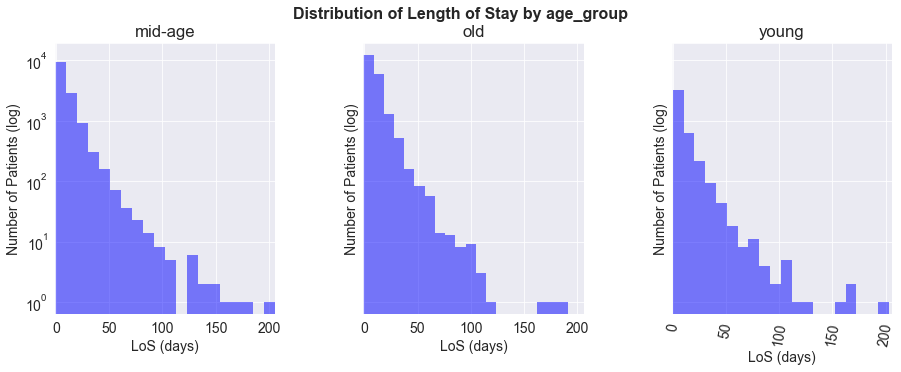

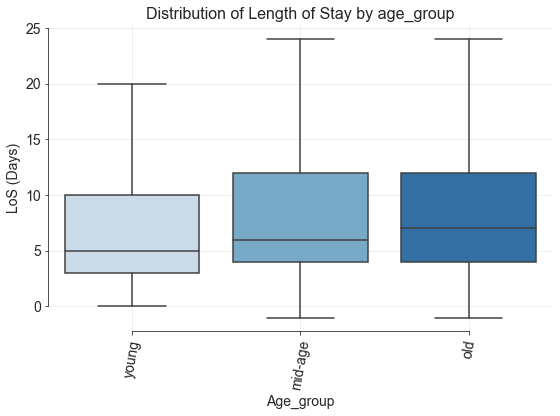

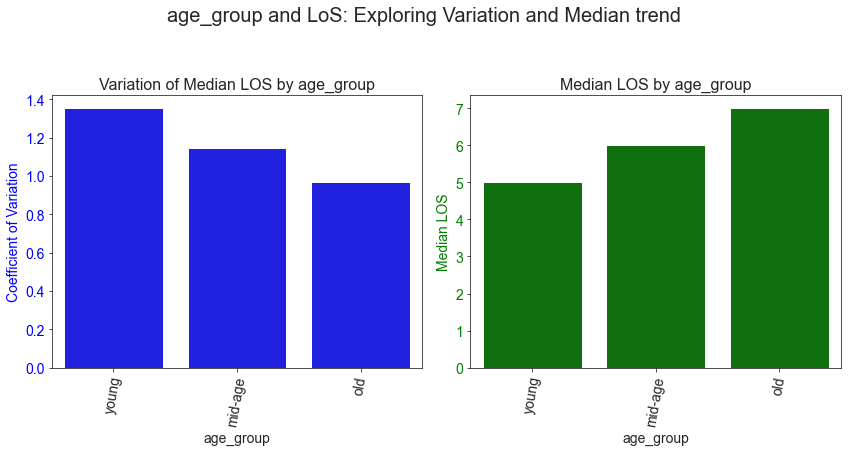

<Figure size 432x288 with 0 Axes>

In [35]:
plot_stats_by_column(comobiditiesdf,'age_group')

Clearly the majority of patients in the dataset are in the 'old' group, followed by the 'mid-age' group and then the 'young' group.

could be that diseases and medical conditions tend to be more common in older individuals, which would explain why the 'old' group is also fairly large. Additionally, the dataset includes only patients who are at least 16 years old, which would naturally exclude a significant proportion of the 'young' group.

Another possibility is that the population being studied (i.e. the patients in the dataset) may simply have a higher proportion of middle-aged and older individuals compared to the general population. This could be due to various factors, such as the types of medical conditions or diseases being studied, the location or demographic characteristics of the healthcare facility where the data was collected. Further analysis and tests will be done to confirm these 


We can see that the median LOS tends to increase with age, with the 'old' group having the highest median LOS. We can also see that there is more variation in LOS within the 'mid-age' and 'old' groups, as evidenced by the longer whiskers and more outliers. further statistical test will be done to confirm if there is a significant differnce in the median age groups

The "young" group has a mean age of 8.75 years, with a standard deviation of 11.58 years. This group has 2,141 members. The coefficient of variation (CV) for this group is 1.32, which indicates a moderate level of variability in age.

The "mid-age" group has a mean age of 10.20 years, with a standard deviation of 12.44 years. This group is the largest, with 13,227 members. The CV for this group is 1.22, indicating a moderate level of variability in age.

The "old" group has a mean age of 9.77 years, with a standard deviation of 9.33 years. This group is the second-largest, with 23,259 members. The CV for this group is 0.96, indicating a relatively low level of variability in age.

##  Admission Type and Length of Stay

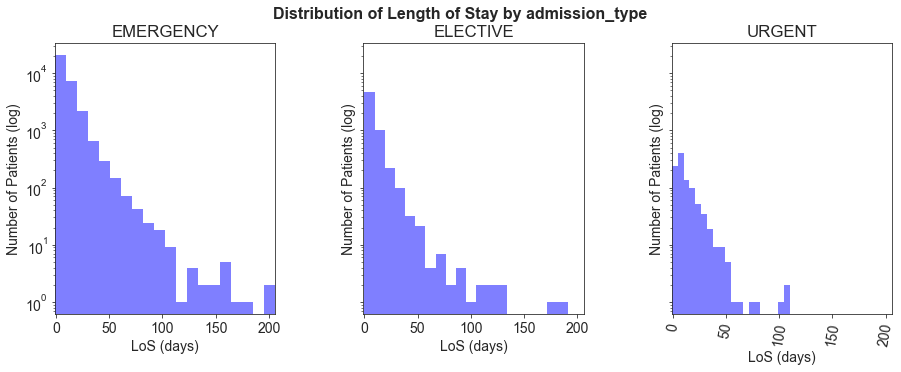

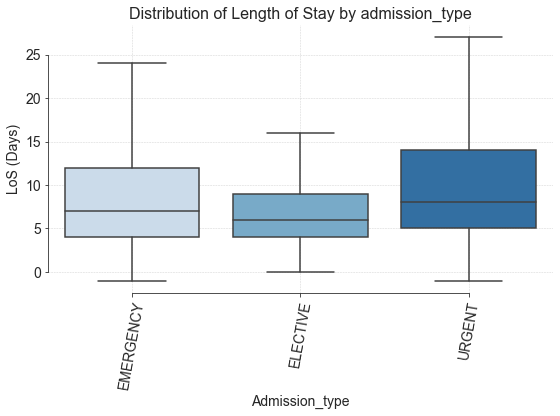

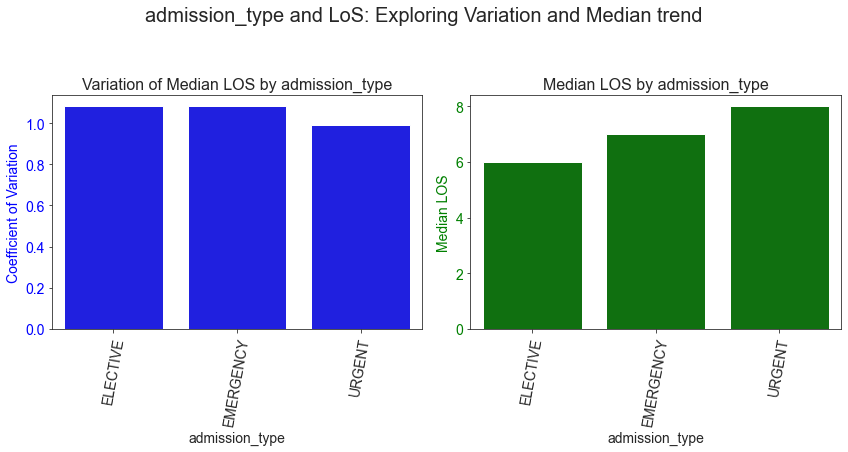

<Figure size 432x288 with 0 Axes>

In [36]:
plot_stats_by_column(comobiditiesdf,'admission_type')

## Discharge location and LoS

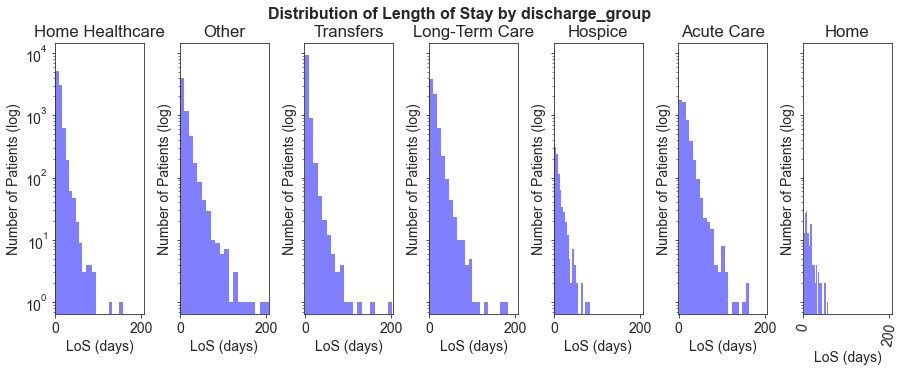

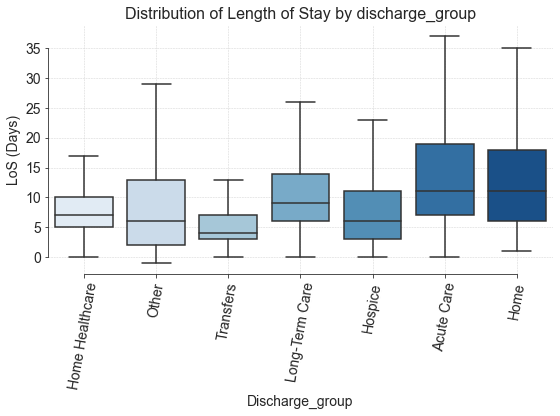

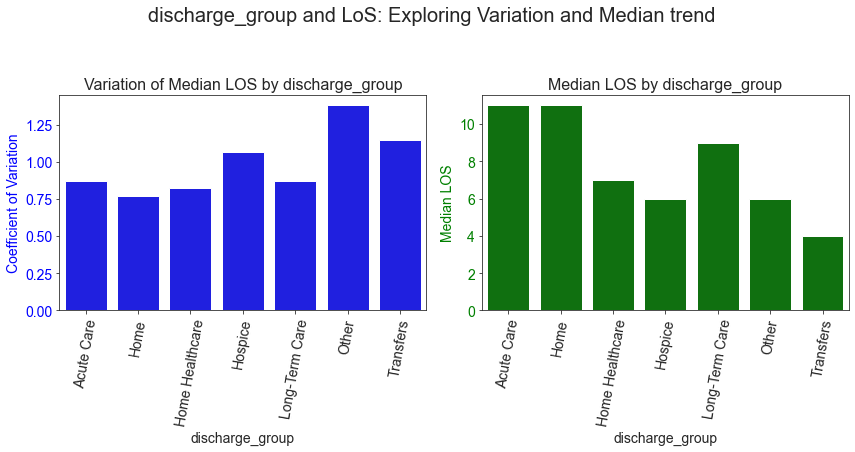

<Figure size 432x288 with 0 Axes>

In [37]:
#grouping discharge location 

data = ['DISC-TRAN CANCER/CHLDRN H', 'HOME HEALTH CARE', 'HOME', 'DEAD/EXPIRED', 'REHAB/DISTINCT PART HOSP', 'LONG TERM CARE HOSPITAL', 'DISC-TRAN TO FEDERAL HC', 'SNF', 'HOSPICE-MEDICAL FACILITY', 'HOME WITH HOME IV PROVIDR', 'HOSPICE-HOME', 'LEFT AGAINST MEDICAL ADVI', 'SHORT TERM HOSPITAL', 'DISCH-TRAN TO PSYCH HOSP', 'OTHER FACILITY', 'ICF', 'SNF-MEDICAID ONLY CERTIF']

groups = {
    'Acute Care': ['SHORT TERM HOSPITAL', 'REHAB/DISTINCT PART HOSP'],
    'Long-Term Care': ['LONG TERM CARE HOSPITAL', 'SNF', 'ICF', 'SNF-MEDICAID ONLY CERTIF'],
    'Home Healthcare': ['HOME HEALTH CARE', 'HOME WITH HOME IV PROVIDR'],
    'Home':['HOME','HOSPICE-HOME'],
    'Hospice': ['HOSPICE-MEDICAL FACILITY'],
    'Transfers': ['DISC-TRAN CANCER/CHLDRN H', 'DISC-TRAN TO FEDERAL HC', 'DISCH-TRAN TO PSYCH HOSP']
}
# Initialize an empty dictionary to store the grouped data
grouped_data = {}
# Loop through each group in the 'groups' dictionary
for group, values in groups.items():
    grouped_data[group] = [d for d in data if d in values]

# Create a list of conditions based on the discharge location of each patient in 'comobiditiesdf'
conditions = [
    comobiditiesdf['discharge_location'].isin(groups['Acute Care']),
    comobiditiesdf['discharge_location'].isin(groups['Long-Term Care']),
    comobiditiesdf['discharge_location'].isin(groups['Home Healthcare']),
    comobiditiesdf['discharge_location'].isin(groups['Hospice']),
    comobiditiesdf['discharge_location'].isin(groups['Transfers']),
    comobiditiesdf['discharge_location'].isin(groups['Home'])
]
# Create a list of choices for each condition
choices = ['Acute Care', 'Long-Term Care', 'Home Healthcare','Home','Hospice', 'Transfers']
# Create a new column in 'comobiditiesdf' based on the conditions and choices, with a default value of 'Other
comobiditiesdf['discharge_group'] = np.select(conditions, choices, default='Other')



plot_stats_by_column(comobiditiesdf,'discharge_group')

## Observation
From the plot, we can see that the majority of patients are discharged to Home Health(the second bar), followed by Long-Term Care and Acute Care (the forth and fifth bars). There are also some patients who are discharged to Hospice and Transfers (the first and fifth bars), but these groups have much lower counts compared to the four groups.

## Insurance and Length of Stay

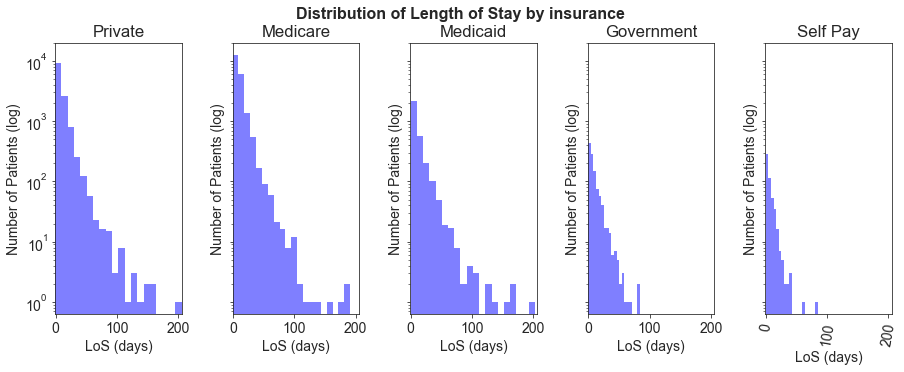

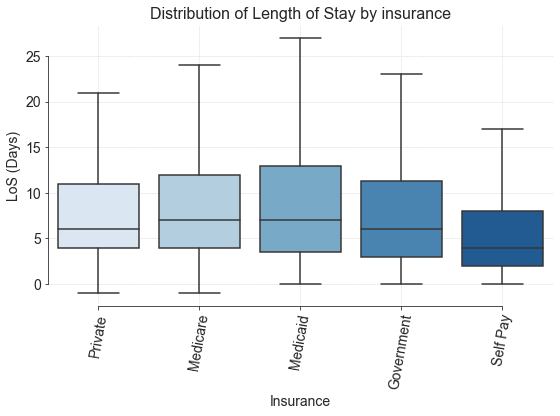

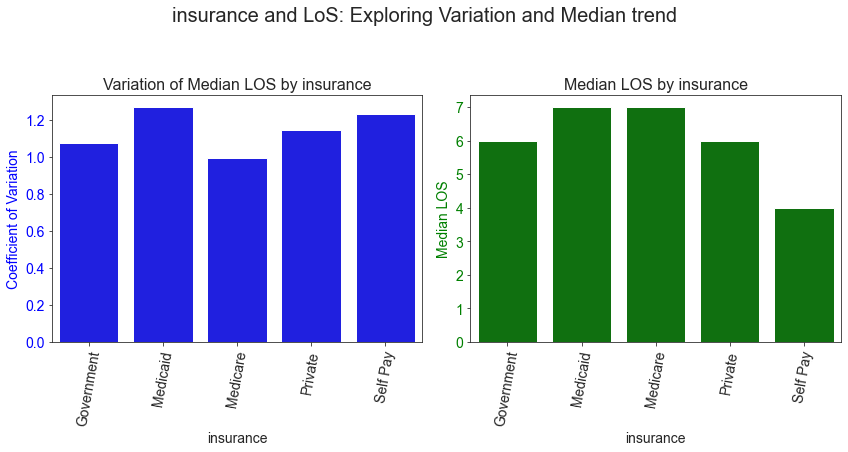

<Figure size 432x288 with 0 Axes>

In [38]:
#encoding the insurance categories
comobiditiesdf['insurance_enc']= np.where(comobiditiesdf['insurance'] == 'Private', 1, 
                                          np.where(comobiditiesdf['insurance']== 'Medicare',2,
                                                   np.where(comobiditiesdf['insurance']== 'Medicaid',3,
                                                           np.where(comobiditiesdf['insurance']=='Self Pay',4,5))))
comobiditiesdf.head()

plot_stats_by_column(comobiditiesdf,'insurance')

## Religion and Length of stay

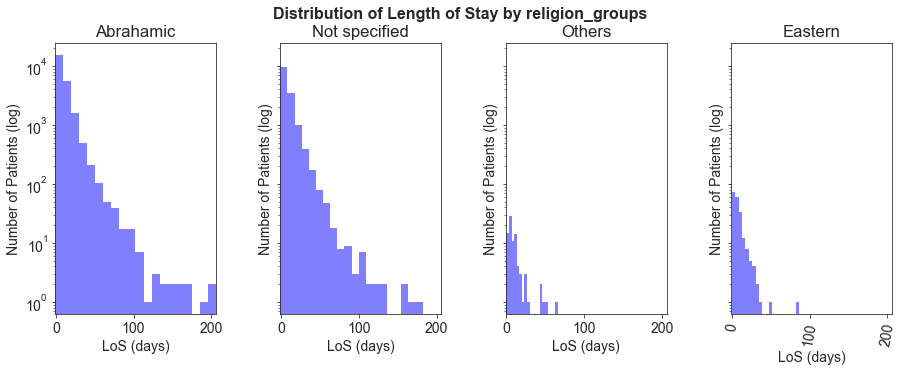

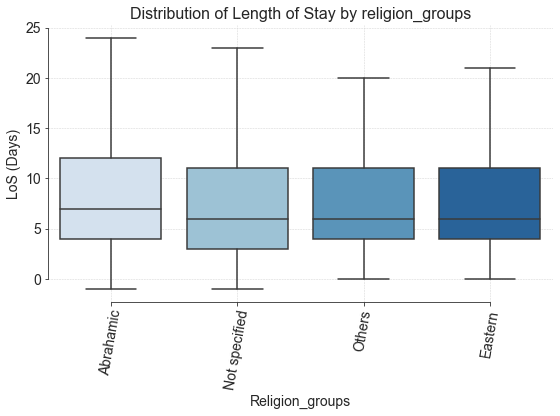

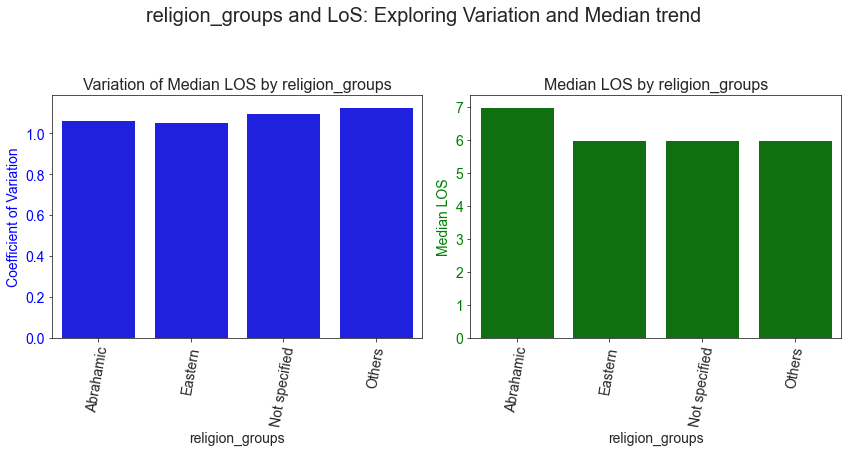

<Figure size 432x288 with 0 Axes>

In [39]:
data = ['UNOBTAINABLE', 'CATHOLIC', 'PROTESTANT QUAKER', 'NOT SPECIFIED',
       'JEWISH', 'BUDDHIST', "JEHOVAH'S WITNESS", 'OTHER', 'NONE',
       'GREEK ORTHODOX', 'EPISCOPALIAN', 'CHRISTIAN SCIENTIST', 'HEBREW',
       'METHODIST', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'BAPTIST',
       '7TH DAY ADVENTIST', 'MUSLIM', 'ROMANIAN EAST. ORTH', 'LUTHERAN']

groups = {
    'Abrahamic': ['CATHOLIC', 'PROTESTANT QUAKER', 'JEWISH', 'JEHOVAH\'S WITNESS', 'GREEK ORTHODOX', 'EPISCOPALIAN', 
                  'CHRISTIAN SCIENTIST', 'HEBREW', 'METHODIST', 'BAPTIST', '7th DAY ADVENTIST', 'MUSLIM', 'ROMANIAN EAST ORTH', 
                  'LUTHERAN'],
    'Eastern': ['BUDDHIST', 'HINDU'],
    
    'Others': ['UNITARIAN-UNIVERSALIST']
}

# Initialize an empty dictionary to store the grouped data
grouped_data = {}
for group, values in groups.items():
    grouped_data[group] = [d for d in data if d in values]

# Create a list of conditions based on the discharge location of each patient in 'comobiditiesdf'
conditions = [
    comobiditiesdf['religion'].isin(groups['Abrahamic']),
    comobiditiesdf['religion'].isin(groups['Eastern']),
    comobiditiesdf['religion'].isin(groups['Others']),
]   
# Create a new column in 'comobiditiesdf' based on the conditions and choices, with a default value of 'Other
choices = ['Abrahamic', 'Eastern', 'Others']
comobiditiesdf['religion_groups'] = np.select(conditions, choices, default='Not specified')

comobiditiesdf.head()


plot_stats_by_column(comobiditiesdf,'religion_groups')

## ETHINICITY AND LENGTH OF STAY

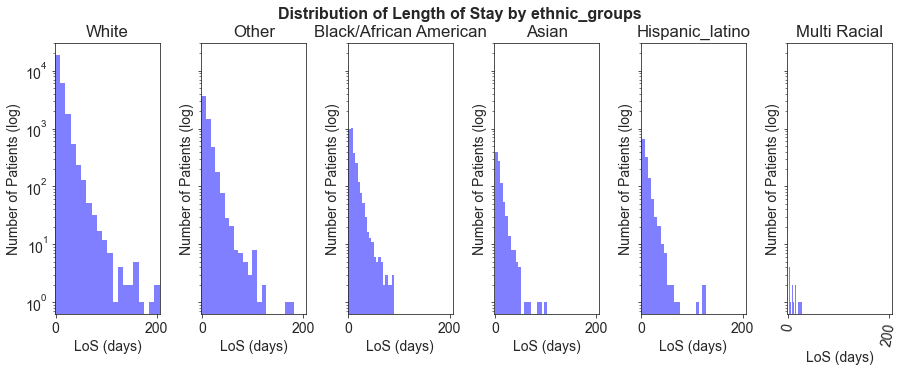

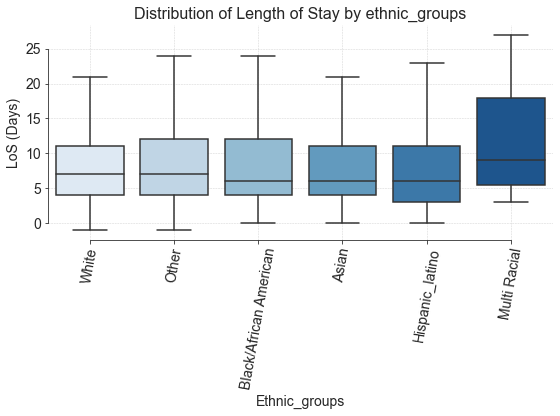

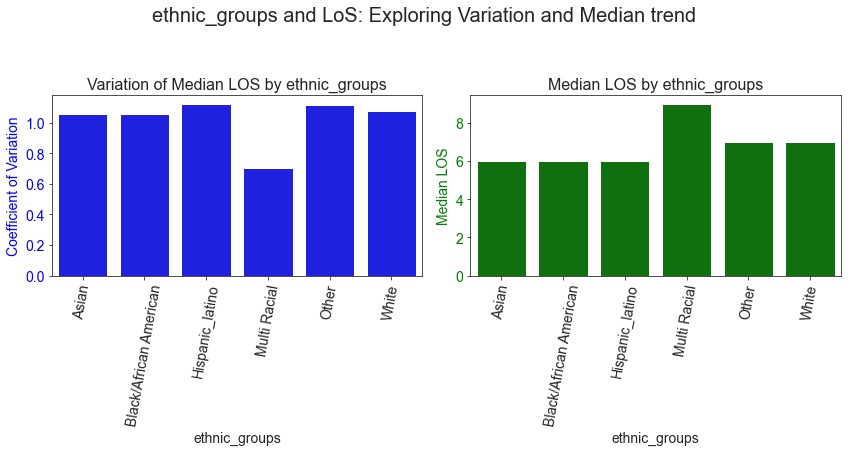

<Figure size 432x288 with 0 Axes>

In [40]:
data = ['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'HISPANIC OR LATINO', 'PATIENT DECLINED TO ANSWER',
       'BLACK/AFRICAN AMERICAN', 'ASIAN', 'HISPANIC/LATINO - GUATEMALAN',
       'OTHER', 'ASIAN - VIETNAMESE', 'AMERICAN INDIAN/ALASKA NATIVE',
       'WHITE - RUSSIAN', 'HISPANIC/LATINO - PUERTO RICAN',
       'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN', 'PORTUGUESE',
       'CARIBBEAN ISLAND', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'WHITE - BRAZILIAN',
       'ASIAN - KOREAN', 'HISPANIC/LATINO - COLOMBIAN', 'SOUTH AMERICAN',
       'ASIAN - THAI', 'HISPANIC/LATINO - HONDURAN',
       'HISPANIC/LATINO - CUBAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'MIDDLE EASTERN',
       'ASIAN - OTHER', 'HISPANIC/LATINO - MEXICAN',
       'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'ASIAN - JAPANESE']



#creating groups for ethnicity
groups = {
    'White': ['WHITE','WHITE - RUSSIAN','WHITE - OTHER EUROPEAN','WHITE - EASTERN EUROPEAN','WHITE - BRAZILIAN'],
    'Hispanic_latino': ['HISPANIC OR LATINO','HISPANIC/LATINO - GUATEMALAN','HISPANIC/LATINO - PUERTO RICAN',
                        'HISPANIC/LATINO - SALVADORAN','HISPANIC/LATINO - DOMINICAN',
                        'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)','HISPANIC/LATINO - COLOMBIAN',
                        'HISPANIC/LATINO - HONDURAN','HISPANIC/LATINO - CUBAN','HISPANIC/LATINO - MEXICAN'],
    
    'Black/African American': ['BLACK/AFRICAN AMERICAN','BLACK/AFRICAN','BLACK/CAPE VERDEAN','BLACK/HAITIAN'],
    'Asian':  ['ASIAN','ASIAN - VIETNAMESE','ASIAN - CHINESE','ASIAN - ASIAN INDIAN','ASIAN - FILIPINO','ASIAN - CAMBODIAN',
              'ASIAN - KOREAN','ASIAN - THAI','ASIAN - JAPANESE'],
    'Other': ['MULTI RACE ETHNICITY','PATIENT DECLINED TO ANSWER','OTHER','PORTUGUESE','CARIBBEAN ISLAND',
                            'SOUTH AMERICAN','NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','MIDDLE EASTERN','UNABLE TO OBTAIN'],
    'Multi Racial': ['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']
}



# Initialize an empty dictionary to store the grouped data
grouped_data = {}
for group, values in groups.items():
    grouped_data[group] = [d for d in data if d in values]

# Create a list of conditions based on the discharge location of each patient in 'comobiditiesdf'
conditions = [
    comobiditiesdf['ethnicity'].isin(groups['White']),
    comobiditiesdf['ethnicity'].isin(groups['Hispanic_latino']),
    comobiditiesdf['ethnicity'].isin(groups['Black/African American']),
    comobiditiesdf['ethnicity'].isin(groups['Asian']),
    comobiditiesdf['ethnicity'].isin(groups['Multi Racial']),
    comobiditiesdf['ethnicity'].isin(groups['Other'])
]   
# Create a new column in 'comobiditiesdf' based on the conditions and choices, with a default value of 'Other
choices = ['White','Hispanic_latino','Black/African American','Asian','Multi Racial','Other']
comobiditiesdf['ethnic_groups'] = np.select(conditions, choices, default = 'Other')

comobiditiesdf.head()

#encoding ethnicity column
comobiditiesdf['ethnic_enc']= np.where(comobiditiesdf['ethnic_groups'] == 'White', 1, 
                                          np.where(comobiditiesdf['ethnic_groups']== 'Black/African American',2,
                                                          np.where(comobiditiesdf['ethnic_groups']=='Multi Racial',3,
                                                                   np.where(comobiditiesdf['ethnic_groups']== 'Hispanic_latino',4,
                                                                           np.where(comobiditiesdf['ethnic_groups']== 'Other',5,6)))))

comobiditiesdf.head()


plot_stats_by_column(comobiditiesdf,'ethnic_groups')

## Gender and Length of Stay

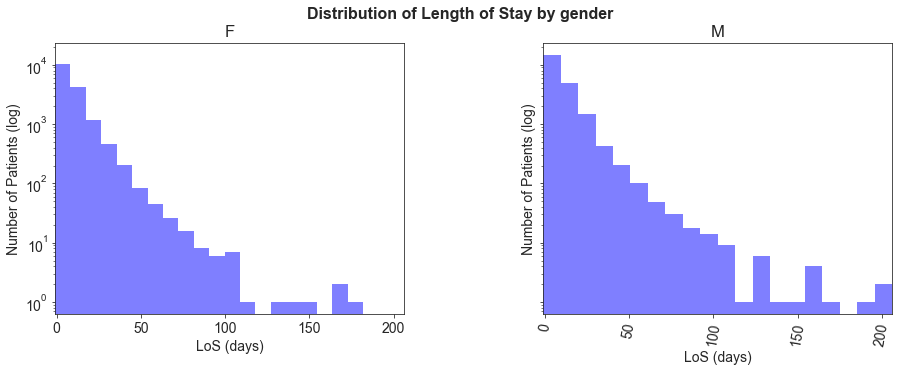

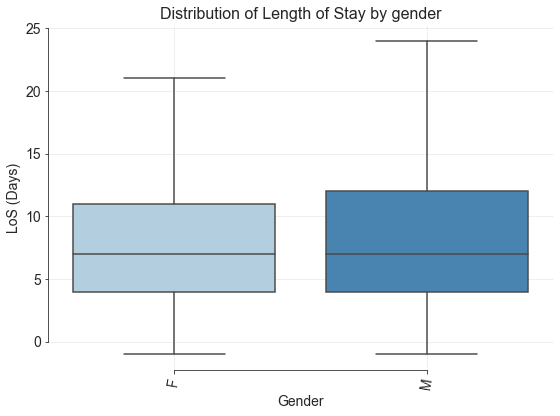

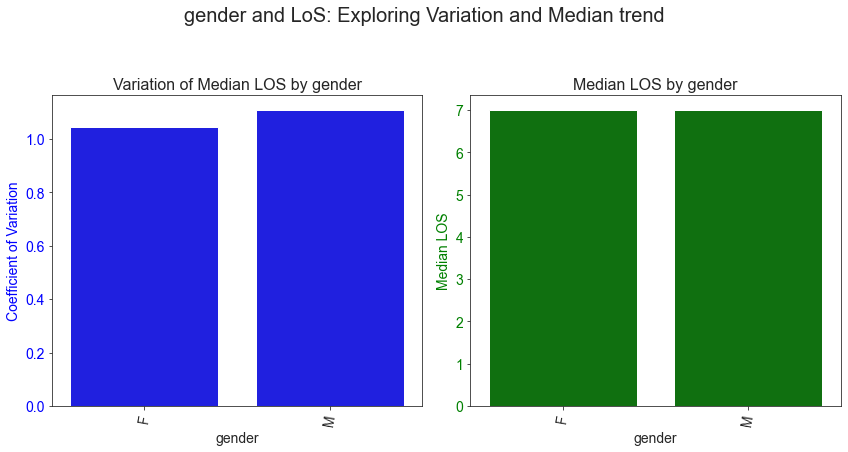

<Figure size 432x288 with 0 Axes>

In [41]:
# Calculate coefficient of variation for los by religion group
comobiditiesdf['gender_cv'] = comobiditiesdf['los'].std() / comobiditiesdf['los'].mean()

# Group by religion group and calculate los mean and cv
gender_stats = comobiditiesdf.groupby('gender')['los'].agg(['mean', 'std', 'count'])
gender_stats['cv'] = gender_stats['std'] / gender_stats['mean']
gender_stats

plot_stats_by_column(comobiditiesdf,'gender')


In [43]:
gender_stats = comobiditiesdf.groupby('gender')['los'].agg(['mean','median', 'std', 'count']) #calculating summary statistics of gender
gender_stats

,mean,median,std,count
gender,,,,
F,9.391566,7.0,9.806406,16766
M,9.700197,7.0,10.745783,21871


## Marital Status and Length of Stay

In [57]:
comobiditiesdf['marital_status'].unique()

array(['SINGLE', 'MARRIED', 'SEPARATED', 'WIDOWED', 'DIVORCED',
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

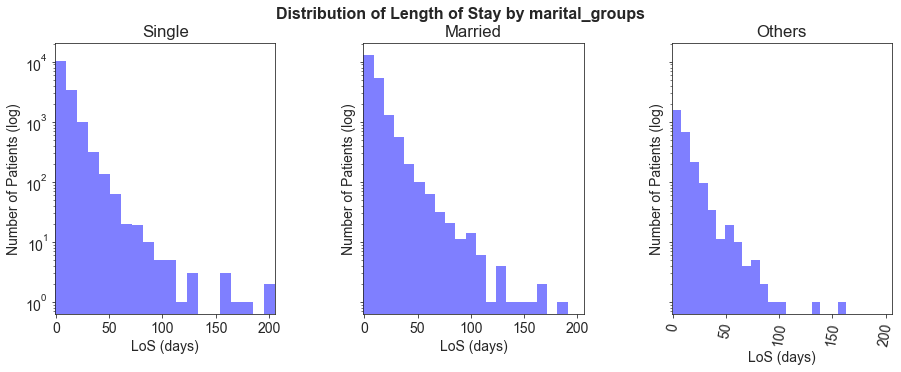

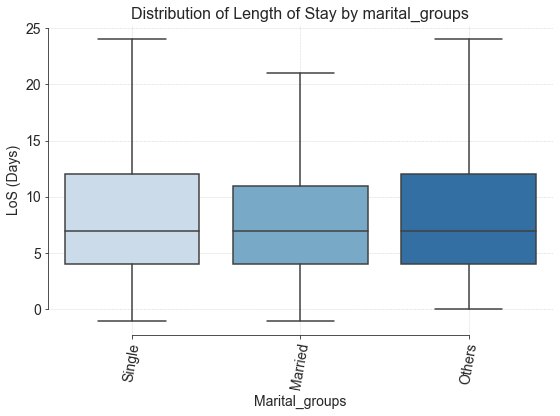

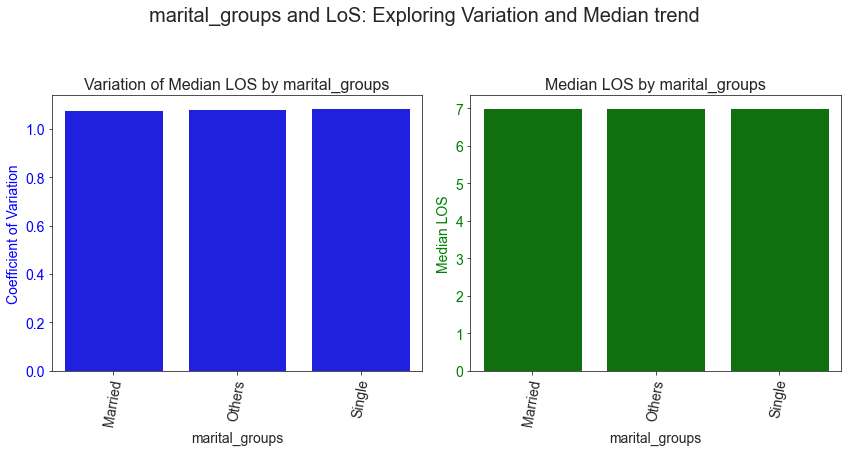

<Figure size 432x288 with 0 Axes>

In [44]:
#grouping the data into single and married
data = ['SINGLE', 'MARRIED', 'SEPARATED', 'WIDOWED', 'DIVORCED',
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER']

groups = {
    'Single': ['SINGLE','SEPARATED','WIDOWED'],
    'Married': ['MARRIED','LIFE PARTNER'],
}

# Initialize an empty dictionary to store the grouped data
grouped_data = {}
for group, values in groups.items():
    grouped_data[group] = [d for d in data if d in values]

# Create a list of conditions based on the discharge location of each patient in 'comobiditiesdf'
conditions = [
    comobiditiesdf['marital_status'].isin(groups['Single']),
    comobiditiesdf['marital_status'].isin(groups['Married']),
]
# Create a new column in 'comobiditiesdf' based on the conditions and choices, with a default value of 'Other
choices = ['Single', 'Married']
comobiditiesdf['marital_groups'] = np.select(conditions, choices, default='Others')


#encoding marital status column
comobiditiesdf['marital_enc']= np.where(comobiditiesdf['marital_groups'] == 'Single', 1,
                                        np.where(comobiditiesdf['marital_groups']=='Married',2,3))

plot_stats_by_column(comobiditiesdf,'marital_groups')


## Diagnosis and Length of Stay

In [69]:
comobiditiesdf.head()

,age,los,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,religion,marital_status,...,rel_enc,religion_cv,ethnic_groups,ethnic_enc,ethnic_cv,gender_enc,gender_cv,marital_groups,marital_enc,marital_cv
0,48.0,8.0,4,185777,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,PROTESTANT QUAKER,SINGLE,...,1,1.079652,White,1,1.079652,1,1.079652,Single,1,1.079652
9,66.0,16.0,6,107064,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NOT SPECIFIED,MARRIED,...,2,1.079652,White,1,1.079652,1,1.079652,Married,2,1.079652
17,42.0,5.0,9,150750,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,MARRIED,...,2,1.079652,Other,5,1.079652,2,1.079652,Married,2,1.079652
23,50.0,26.0,11,194540,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,MARRIED,...,2,1.079652,White,1,1.079652,1,1.079652,Married,2,1.079652
24,72.0,13.0,12,112213,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,JEWISH,MARRIED,...,1,1.079652,White,1,1.079652,2,1.079652,Married,2,1.079652


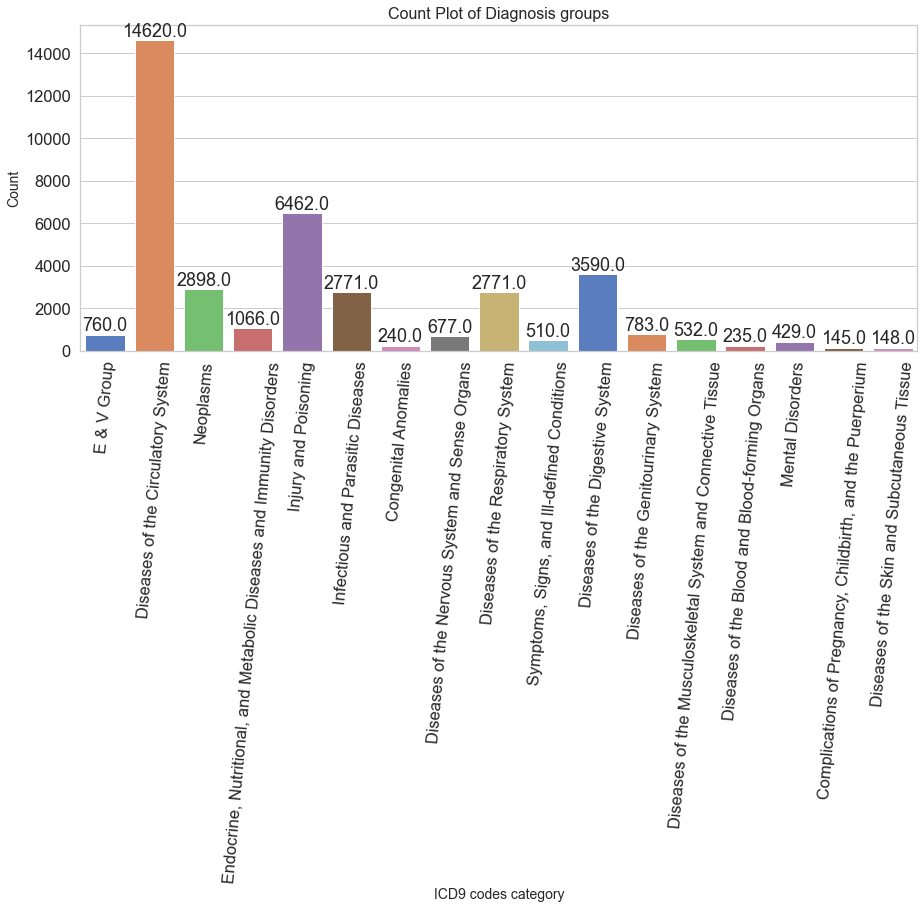

In [48]:
# Create a new figure with a width of 15 inches and a height of 6 inches.
plt.figure(figsize=(15, 6))

# Create a count plot using Seaborn library, with the 'ccs_group' column from the 'comobiditiesdf' DataFrame as the x-axis 
# and the count of each category as the y-axis. The 'muted' palette is used to color the bars.
ax = sns.countplot(x='ccs_group', data=comobiditiesdf, palette='muted')

# Add a label to the x-axis of the plot with a font size of 14.
plt.xlabel('ICD9 codes category', fontsize=14)

# Add a label to the y-axis of the plot with a font size of 14.
plt.ylabel('Count', fontsize=14)

# Rotate the x-axis labels by 85 degrees to prevent overlap.
plt.xticks(rotation = 85)

# Add a title to the plot with a font size of 16.
plt.title('Count Plot of Diagnosis groups', fontsize=16)

# Add the count of each category on top of its respective bar in the plot. The text is centered on top of the bar and aligned to the bottom.
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), p.get_height(), ha='center', va='bottom')



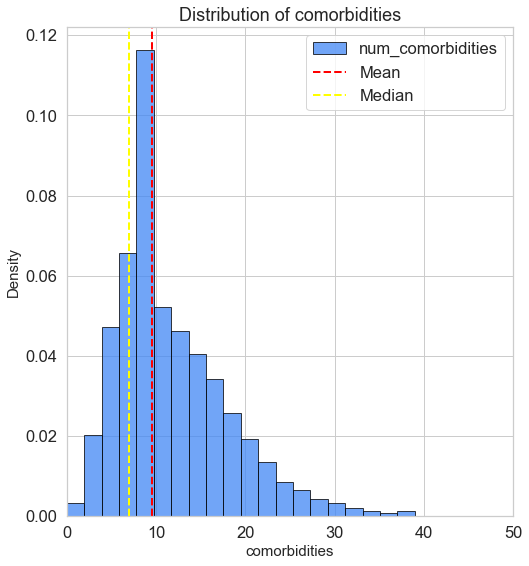

count    38637.000000
mean        11.627585
std          6.417366
min          0.000000
25%          7.000000
50%         10.000000
75%         15.000000
max         39.000000
Name: num_comorbidities, dtype: float64

In [51]:
# Create a histogram of the los column
comobiditiesdf.num_comorbidities.plot.hist(bins=20, figsize=(8,9), color='#4287f5', alpha=0.75, edgecolor='black',density=True)
plt.xlim(0,50)
plt.title('Distribution of comorbidities',fontsize =18)
plt.xlabel('comorbidities',fontsize = 15)
plt.ylabel('Density',fontsize = 15)

# Calculate the mean and median values of the los column
mean_como = comobiditiesdf.los.mean()
median_como = comobiditiesdf.los.median()

# Add vertical dashed lines for the mean and median values
plt.axvline(mean_los, color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(median_los, color='yellow', linestyle='--', linewidth=2, label='Median')

# Add a legend to the plot
plt.legend()

# Display the figure
plt.show()
comobiditiesdf['num_comorbidities'].describe()

## Kruskal - Walli's Test

In [52]:

import scipy.stats as stats
import pandas as pd

# Define a function for the Kruskal-Wallis test
def kruskal_wallis(df, columns, group_var):
    
    # Create an empty list to store the results
    results = []
    
    # Loop through the list of columns to perform the test on
    for col in columns:
        
        # Group the dataframe by the group variable and the current column
        groups = df.groupby(group_var)[col]
        
        # Create a list of arrays, where each array contains the values of the current column for each group
        group_arrays = [group[1].values for group in groups]
        
        # Perform the Kruskal-Wallis test on the list of arrays
        kw_stat, p_value = stats.kruskal(*group_arrays)
        
        # Append the results of the Kruskal-Wallis test to the list of results
        results.append((col, kw_stat, p_value))
    
    # Convert the list of results into a dataframe
    results_df = pd.DataFrame(results, columns=['Features', 'Kruskal-Wallis test statistic', 'p-value'])
    
    # Return the dataframe
    return results_df


result_df = kruskal_wallis(comobiditiesdf, ['discharge_group', 'admission_type', 'insurance','admission_location','marital_status',
                                           'gender','age_group','religion_groups','num_comorbidities','ethnic_groups'], 'los')
print(result_df)


# set the p-value threshold for selecting predictors
p_value_threshold = 0.05

# filter the result dataframe based on the p-value threshold
strong_predictors = result_df[result_df['p-value'] < p_value_threshold]

# print the selected predictors
print("The strongest predictors are:")
print(strong_predictors['Features'].tolist())

             Features  Kruskal-Wallis test statistic        p-value
0     discharge_group                    5670.831730   0.000000e+00
1      admission_type                    1052.413050  1.080457e-143
2           insurance                     263.200146   6.553527e-11
3  admission_location                     532.114382   9.431394e-50
4      marital_status                     121.156701   7.199158e-01
5              gender                     106.774346   9.404418e-01
6           age_group                     177.042744   4.573652e-03
7     religion_groups                     378.515923   7.022602e-26
8   num_comorbidities                    5907.291046   0.000000e+00
9       ethnic_groups                     172.869658   8.344087e-03
The strongest predictors are:
['discharge_group', 'admission_type', 'insurance', 'admission_location', 'age_group', 'religion_groups', 'num_comorbidities', 'ethnic_groups']


In [54]:
#selects strongest predictors and saving in a pandas dataframe
best_pred_corrdf = comobiditiesdf[['los','age','admission_type','admission_location','discharge_location',
                                   'religion','num_comorbidities','insurance','diagnosis']]
best_pred_corrdf.head()

,los,age,admission_type,admission_location,discharge_location,religion,num_comorbidities,insurance,diagnosis
0,8.0,48.0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,PROTESTANT QUAKER,9,Private,"FEVER,DEHYDRATION,FAILURE TO THRIVE"
9,16.0,66.0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,NOT SPECIFIED,8,Medicare,CHRONIC RENAL FAILURE/SDA
17,5.0,42.0,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,UNOBTAINABLE,6,Medicaid,HEMORRHAGIC CVA
23,26.0,50.0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,OTHER,1,Private,BRAIN MASS
24,13.0,72.0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,JEWISH,9,Medicare,PANCREATIC CANCER/SDA


In [55]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# load the data into a pandas dataframe
#data = pd.read_csv('data.csv')

# extract the features and target variable
X = best_pred_corrdf.drop(['los'],axis=1)

y = best_pred_corrdf['los']# first column

# calculate the Spearman's rank correlation coefficient between each feature and the target variable
correlations = {}
for feature in X.columns:
    correlation, p_value = spearmanr(X[feature], y)
    correlations[feature] = correlation

# print the correlation coefficients for each feature
for feature, correlation in correlations.items():
    print('Correlation coefficient for', feature, ':', correlation)


Correlation coefficient for age : 0.055959630641887005
Correlation coefficient for admission_type : 0.04219605245240447
Correlation coefficient for admission_location : 0.08284842113811458
Correlation coefficient for discharge_location : 0.3159840918523008
Correlation coefficient for religion : -0.05786874638727967
Correlation coefficient for num_comorbidities : 0.38404024754710375
Correlation coefficient for insurance : -0.053151475945831986
Correlation coefficient for diagnosis : -0.0046058652184606825


## Data Preprocessing

In [56]:
# select only the columns corresponding to the best predictors
best_predictorsdf = comobiditiesdf[['los','age','admission_type','admission_location','discharge_location',
                                   'insurance','num_comorbidities','religion','diagnosis']]

# print the new dataframe
best_predictorsdf.shape


(38637, 9)

In [57]:
model_data = best_predictorsdf.copy();# copy data to new varible 
model_data['los'].unique()

expired = model_data.loc[model_data['los'] == -1]
model_data = model_data.drop(expired.index) # droping values with -1 LOS

In [58]:
# Import the LabelEncoder class from the scikit-learn library
from sklearn.preprocessing import LabelEncoder

# Create an instance of the LabelEncoder class
le = LabelEncoder()

# Loop through each column in the 'model_data' DataFrame
for i in model_data.columns:
    
    # Check if the column datatype is 'object'
    if model_data[i].dtypes == 'object':
        
        # Use the LabelEncoder instance to transform the values in the current column to numerical values
        # The 'reshape' method is used to ensure that the input to the 'fit_transform' method is a 2D array
        model_data[i]=le.fit_transform(model_data[i].values.reshape(-1,1))


In [59]:
#grouping LOS according to short, intermediate, prolonged and extended and keeping in a new variable los_category
los_category = []
for row in model_data['los']:
    if  0<= row <= 3:
        los_category.append(1) #short 
    elif 3< row <= 9:
        los_category.append(2) #intermediate 
    elif 9 < row <= 21:
        los_category.append(3) #prolonged
    else:
        los_category.append(4)#extended
model_data['los_category'] = los_category # adding a new column to the dataset this will be my target variable
model_data;

In [60]:
#defininig dependent and independent variables
X_b = model_data.drop(['los','los_category'], axis=1)
y_b = model_data['los_category']
y.shape

(38637,)

In [61]:
X_b.shape

(38624, 8)

In [62]:
y = y_b.copy() # coping the dependent variable into a new variable

In [63]:
X = X_b.copy()
X # coping the independent variable into a new variable

,age,admission_type,admission_location,discharge_location,insurance,num_comorbidities,religion,diagnosis
0,48.0,1,2,6,3,9,16,4811
9,66.0,0,4,5,2,8,14,3017
17,42.0,1,2,0,1,6,19,5395
23,50.0,1,2,5,3,1,15,2049
24,72.0,0,4,0,2,9,10,8306
...,...,...,...,...,...,...,...,...
1325635,83.0,1,1,11,2,9,3,2440
1325644,79.0,0,4,5,2,6,16,6464
1325650,67.0,1,1,0,2,24,16,11205
1325720,32.0,1,2,4,3,8,14,11212


In [64]:
#normalising the dependent variable using standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[-0.9107636 ,  0.31937257, -0.49580884, ..., -0.40954468,
         0.93213565, -0.36739926],
       [ 0.11695696, -2.13495415,  0.86052805, ..., -0.56535578,
         0.60887522, -0.85549633],
       [-1.25333712,  0.31937257, -0.49580884, ..., -0.87697796,
         1.4170263 , -0.20850924],
       ...,
       [ 0.17405255,  0.31937257, -1.17397728, ...,  1.92762172,
         0.93213565,  1.37222876],
       [-1.82429298,  0.31937257, -0.49580884, ..., -0.56535578,
         0.60887522,  1.37413327],
       [-0.33980773,  0.31937257, -1.17397728, ..., -0.40954468,
         0.60887522, -1.61539328]])

In [65]:
#oversampling the data
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X,y = sm.fit_resample(X,y)

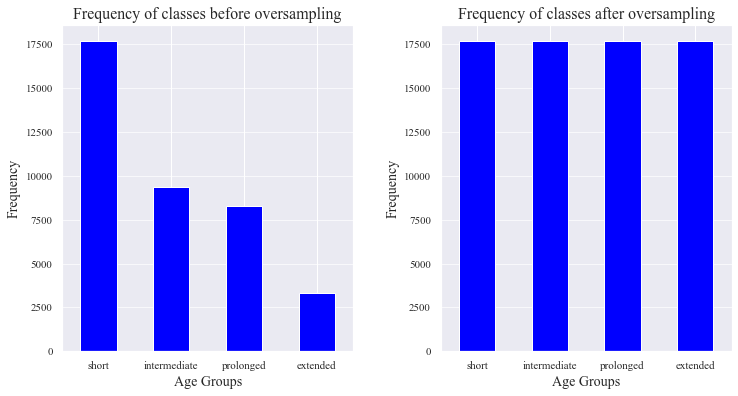

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font to a consistent font with the paper
sns.set(font='Times New Roman')

# Create the subplots with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Modify x-tick labels to "young", "mid-age", and "old"
xtick_labels = ['short', 'intermediate', 'prolonged','extended']

# Plot the first bar chart
y_b.value_counts().plot(kind='bar', color='blue', ax=axs[0])

# Add the grid and labels
axs[0].grid(axis='y', alpha=0.7)
axs[0].set_xlabel('Age Groups', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Frequency of classes before oversampling', fontsize=16)
axs[0].set_xticklabels(xtick_labels, rotation=0)

# Plot the second bar chart
y.value_counts().plot(kind='bar', color='blue', ax=axs[1])

# Add the grid and labels
axs[1].grid(axis='y', alpha=0.7)
axs[1].set_xlabel('Age Groups', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_title('Frequency of classes after oversampling', fontsize=16)
axs[1].set_xticklabels(xtick_labels, rotation=0)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.3)

# Show the chart
plt.show()


In [67]:
len(y)

70808

## Logistics Regression

In [68]:

# Import the necessary libraries for the code
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score

# Create an instance of the OneVsRestClassifier class with LogisticRegression as the estimator
lr = OneVsRestClassifier(LogisticRegression())

# Loop through 100 random states
for i in range(0,100):
    
    # Split the data into training and testing sets with a test size of 20% and the current random state
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state =i, test_size = 0.20)
    
    # Fit the OneVsRestClassifier model on the training data
    lr.fit(X_train,y_train)
    
    # Predict the classes for the training and testing data
    pred_train= lr.predict(X_train)
    pred_test = lr.predict(X_test)
    
    # Check if the training and testing accuracies are equal up to 1 decimal place
    if round(accuracy_score(y_train,pred_train)*100,1)== round(accuracy_score(y_test,pred_test)*100,1):
        
        # Print the model performance metrics for the current random state
        print('At random state',i, 'the model reports:')
        print('At random state:-', i)
        print('Training accuracy is:', accuracy_score(y_train,pred_train)*100)
        print('Testing accuracy is:', accuracy_score(y_test,pred_test)*100)
        print('\n')


At random state 16 the model reports:
At random state:- 16
Training accuracy is: 44.70042015323236
Testing accuracy is: 44.66177093630843


At random state 24 the model reports:
At random state:- 24
Training accuracy is: 44.76220739328461
Testing accuracy is: 44.802993927411386


At random state 32 the model reports:
At random state:- 32
Training accuracy is: 44.718073650390146
Testing accuracy is: 44.7465047309702


At random state 47 the model reports:
At random state:- 47
Training accuracy is: 44.63157151431699
Testing accuracy is: 44.584098291201805


At random state 60 the model reports:
At random state:- 60
Training accuracy is: 44.67570525721145
Testing accuracy is: 44.732382431859904


At random state 82 the model reports:
At random state:- 82
Training accuracy is: 44.77279949157928
Testing accuracy is: 44.824177376076825


At random state 99 the model reports:
At random state:- 99
Training accuracy is: 44.76926879214773
Testing accuracy is: 44.7747493291908




In [168]:
X_test.shape

(11588, 9)

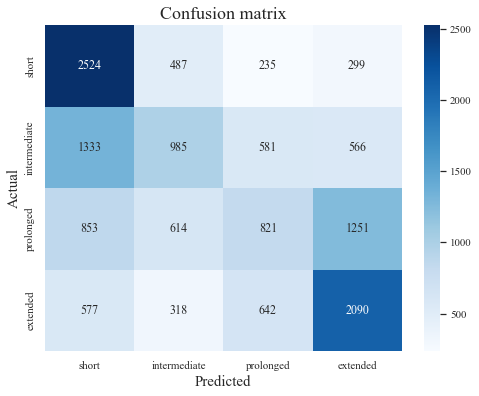

In [114]:
 # Calculate and plot confusion matrix
cm = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
                    xticklabels=['short', 'intermediate','prolonged','extended'], yticklabels=['short', 'intermediate','prolonged','extended'])
plt.xlabel('Predicted',fontsize=15)
plt.ylabel('Actual',fontsize=15)
plt.title('Confusion matrix',fontsize=18)
plt.show()

In [69]:
pred_prob = lr.predict_proba(X_test) #calculating predicted probabilities and checking the shape
pred_prob

array([[0.57715409, 0.26640544, 0.12460648, 0.031834  ],
       [0.04204542, 0.11869499, 0.25528378, 0.5839758 ],
       [0.03124713, 0.22681641, 0.25637977, 0.48555669],
       ...,
       [0.16034771, 0.12698272, 0.20384491, 0.50882465],
       [0.04854865, 0.17833545, 0.33371093, 0.43940497],
       [0.08329723, 0.24712929, 0.36414719, 0.30542629]])

In [71]:
# calulating classification metric report for each class
class_names = ['short', 'intermediate', 'prolonged','extended']
print(classification_report(y_test,pred_test,target_names=class_names))

              precision    recall  f1-score   support

       short       0.47      0.72      0.56      3477
intermediate       0.42      0.28      0.34      3524
   prolonged       0.36      0.22      0.28      3560
    extended       0.48      0.57      0.52      3601

    accuracy                           0.45     14162
   macro avg       0.43      0.45      0.43     14162
weighted avg       0.43      0.45      0.43     14162



In [72]:
# Predict the classes for the testing data using the trained model
pred_lr = lr.predict(X_test)

# Import the necessary libraries for cross-validation
from sklearn.model_selection import cross_val_score

# Compute the accuracy score for the predicted labels and the actual labels
lss = accuracy_score(y_test,pred_lr)

# Loop through cross-validation folds from 2 to 9
for i in range(2,10):
    
    # Compute the cross-validation score for the current number of folds
    lsscore = cross_val_score(lr,X,y, cv =i)
    
    # Compute the mean cross-validation score across all folds
    lsc = lsscore.mean()
    
    # Print the cross-validation and accuracy scores for the current number of folds
    print('At cv:',i)
    print('cross validation score is:-', lsc*100)
    print('accuracy_score is:-',lss*100)
    print('\n')


At cv: 2
cross validation score is:- 42.66043384928256
accuracy_score is:- 44.7747493291908


At cv: 3
cross validation score is:- 43.5091972858585
accuracy_score is:- 44.7747493291908


At cv: 4
cross validation score is:- 43.54310247429669
accuracy_score is:- 44.7747493291908


At cv: 5
cross validation score is:- 43.976659622204714
accuracy_score is:- 44.7747493291908


At cv: 6
cross validation score is:- 43.9427341711544
accuracy_score is:- 44.7747493291908


At cv: 7
cross validation score is:- 44.00489272535474
accuracy_score is:- 44.7747493291908


At cv: 8
cross validation score is:- 44.09671223590555
accuracy_score is:- 44.7747493291908


At cv: 9
cross validation score is:- 44.12212171995935
accuracy_score is:- 44.7747493291908




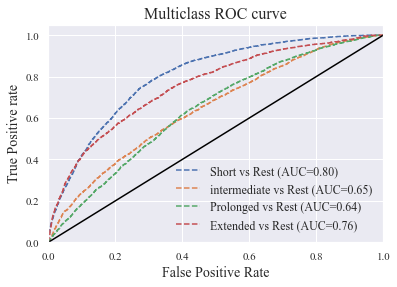

In [74]:
# Plottin ROC AUC curves 

import numpy as np                   # import numpy library for numerical operations
import matplotlib.pyplot as plt      # import pyplot module from matplotlib for plotting
from sklearn.metrics import roc_curve, auc   # import required metrics for computing ROC curve

classes = np.unique(y_test)          # get unique classes in y_test variable
class_names = ['Short','intermediate','Prolonged','Extended'] # create list of class names
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))   # binarize y_test variable

# roc curves for each class
fpr = {}     # dictionary to store false positive rate for each class
tpr = {}     # dictionary to store true positive rate for each class
threshold = {}  # dictionary to store threshold values for each class
roc_auc = {}    # dictionary to store ROC AUC value for each class

n_classes = classes.shape[0]     # get number of classes

# calculate ROC curve and ROC AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plot ROC curve for each class
    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)' % (class_names[i], roc_auc[i]))

# plot diagonal line representing no skill
plt.plot([0, 1], [0, 1], 'black')

# set plot limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC curve',fontsize=16)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive rate',fontsize=14)

# add legend to the plot
plt.legend(loc='lower right',frameon=False,fontsize=12)

# show the plot
plt.show()



## Support Vector Machine

In [121]:
#developing a support vector model and checking the accuracy

from sklearn.svm import SVC  # import the support vector machine classifier

svc = OneVsRestClassifier(SVC())  # create an instance of the one-vs-rest classifier with the support vector machine as the base estimator

svc.fit(X_train, y_train)  # fit the one-vs-rest classifier to the training data

predsvc = svc.predict(X_test)  # make predictions on the test data using the fitted classifier

print(accuracy_score(y_test, predsvc))  # print the accuracy score of the predictions

print(confusion_matrix(y_test,predsvc))  # print the confusion matrix of the predictions

print(classification_report(y_test,predsvc))  # print the classification report of the predictions


0.4927341986455982
[[2544  462  213  326]
 [1335 1045  468  617]
 [ 769  587  677 1506]
 [ 399  262  247 2719]]
              precision    recall  f1-score   support

           1       0.50      0.72      0.59      3545
           2       0.44      0.30      0.36      3465
           3       0.42      0.19      0.26      3539
           4       0.53      0.75      0.62      3627

    accuracy                           0.49     14176
   macro avg       0.47      0.49      0.46     14176
weighted avg       0.47      0.49      0.46     14176

Training accuracy is: 49.86243386243386
Testing accuracy is: 49.27341986455982


In [137]:
# checking cv score for support vector machine classifier
score = cross_val_score(svc,X,y)  # calculate the cross validation scores for the SVC model
print(score)  # print the array of cross validation scores
print(score.mean())  # print the mean of the cross validation scores
print('Difference between accuracy and cross validation score is', accuracy_score(y_test,predsvc)-score.mean())  # print the difference between accuracy score and mean of cross validation score

[0.47528947 0.46582886 0.48121999 0.48383225 0.47938435]
0.47711098559728893
Difference between accuracy and cross validation score is 0.003544196554645551


In [123]:
#checking the predicted probablities

y_score = svc.decision_function(X_test) ## predicted probabilities
y_score
y_prob = np.exp(y_score) / np.sum(np.exp(y_score), axis=1, keepdims=True)


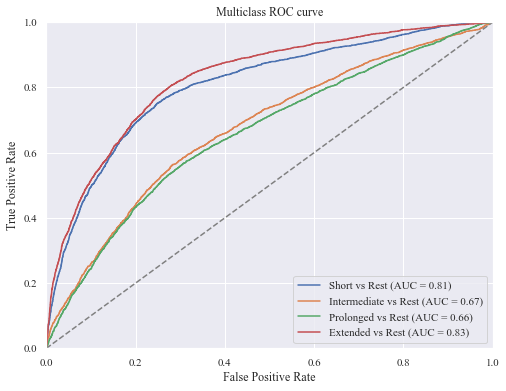

In [124]:
#visualising roc curves showing the perfomance of each class

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

classes = np.unique(y_test)
class_names = ['Short','Intermediate','Prolonged','Extended'] # list of original class names
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

#roc curves
fpr = {} #calculating false positive rates and store in and empty dictionary
tpr = {}#calculating true positive rates and store in and empty dictionary
threshold = {}# dictionary to store threshold values for each class
roc_auc = {}# dictionary to store ROC AUC value for each class

n_classes = classes.shape[0]  #get the number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
   # Plot ROC curves
fig, ax = plt.subplots()
for i in range(n_classes):
    roc_display = plot_roc_curve(svc.estimators_[i], X_test, y_test_binarize[:, i], 
                                 name=f'{class_names[i]} vs Rest', ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Random Forest

In [167]:
#developing Random forest model

# Define an instance of OneVsRestClassifier that uses a RandomForestClassifier as the base estimator
RFC = OneVsRestClassifier(RandomForestClassifier())

# Train the classifier using the training data X_train and y_train
RFC.fit(X_train,y_train)

# Use the trained classifier to make predictions on the test data X_test
predRFC = RFC.predict(X_test)

# Calculate and print the accuracy of the classifier's predictions on the test data
print(accuracy_score(y_test,predRFC))

# Calculate and print a confusion matrix of the classifier's predictions on the test data
print(confusion_matrix(y_test,predRFC))

# Calculate and print a classification report of the classifier's predictions on the test data
print(classification_report(y_test,predRFC))


0.7014261508048574
[[2668  520  201  135]
 [ 673 2042  662  205]
 [ 273  693 2102  466]
 [  67  128  206 3123]]
              precision    recall  f1-score   support

           1       0.72      0.76      0.74      3524
           2       0.60      0.57      0.59      3582
           3       0.66      0.59      0.63      3534
           4       0.79      0.89      0.84      3524

    accuracy                           0.70     14164
   macro avg       0.70      0.70      0.70     14164
weighted avg       0.70      0.70      0.70     14164



In [145]:
pred_prob = RFC.predict_proba(X_test)
pred_prob.shape

(14164, 4)

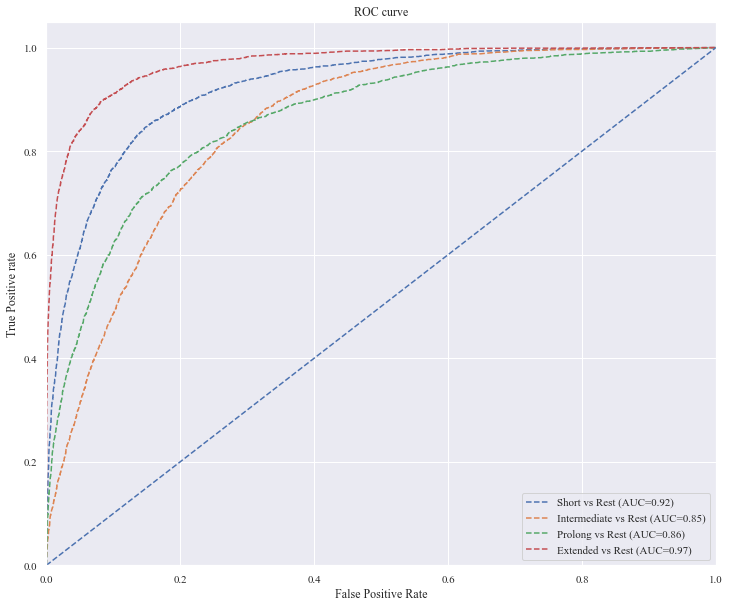

In [147]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve, auc, label_binarize

#classes = np.unique(y_test)
class_names = ['Short','Intermediate','Prolong','Extended']
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

#roc curves
fpr = {}
tpr = {}
threshold = {}
roc_auc = {}

n_classes = classes.shape[0]

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))
    
#plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [149]:
score = cross_val_score(RFC,X,y)
print(score)
print(score.mean())
print('Difference between accuracy and cross validation score is', accuracy_score(y_test,predRFC)-score.mean())

[0.58133296 0.62814177 0.71519345 0.75974301 0.7641203 ]
0.6897062976560293
Difference between accuracy and cross validation score is 0.012849477548715127


In [150]:
#checking accuracy for Gradient boosting classifier
#checking accuracy for Gradient boosting classifier
# Define an instance of OneVsRestClassifier that uses a GradientBoostingClassifier as the base estimator
GB = OneVsRestClassifier(GradientBoostingClassifier())

# Train the classifier using the training data X_train and y_train
GB.fit(X_train,y_train)

# Use the trained classifier to make predictions on the test data X_test
predGB = GB.predict(X_test)

# Calculate and print the accuracy of the classifier's predictions on the test data
print(accuracy_score(y_test, predGB))

# Calculate and print a confusion matrix of the classifier's predictions on the test data
print(confusion_matrix(y_test,predGB))

# Calculate and print a classification report of the classifier's predictions on the test data
print(classification_report(y_test,predGB))


0.5742728042925728
[[2521  412  275  316]
 [ 872 1731  686  293]
 [ 504  661 1276 1093]
 [ 237  112  569 2606]]
              precision    recall  f1-score   support

           1       0.61      0.72      0.66      3524
           2       0.59      0.48      0.53      3582
           3       0.45      0.36      0.40      3534
           4       0.60      0.74      0.67      3524

    accuracy                           0.57     14164
   macro avg       0.57      0.57      0.56     14164
weighted avg       0.57      0.57      0.56     14164



<Figure size 576x432 with 0 Axes>

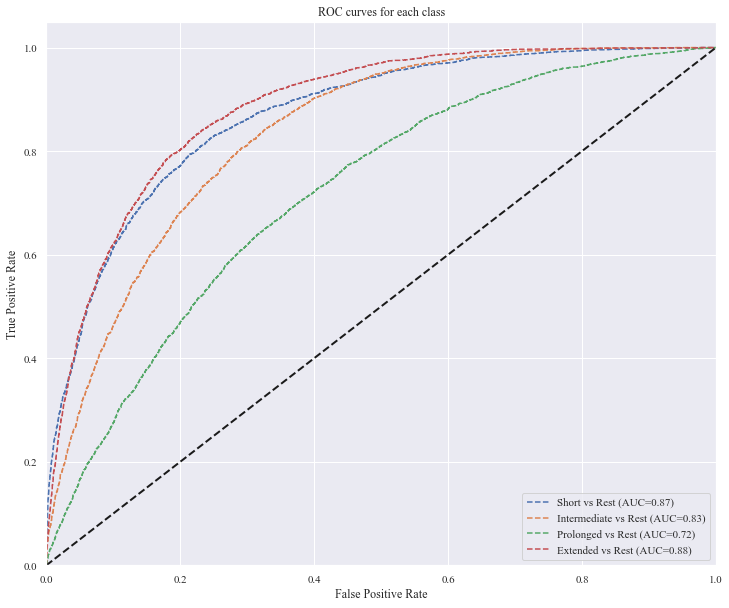

In [155]:
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))
pred_GB = GB.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(classes)
class_names =['Short','Intermediate','Prolonged','Extended']
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(8, 6))
#colors = ['blue', 'red', 'green', 'orange', 'purple'] # Define colors for the curves

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_GB[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))




plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for each class')
plt.legend(loc="lower right")
plt.show()


In [152]:
# Use cross-validation to calculate the score of the classifier on the entire dataset
score = cross_val_score(GB,X,y)

# Print the individual scores for each fold of cross-validation
print(score)

# Print the mean score across all folds of cross-validation
print(score.mean())

# Calculate and print the difference between the accuracy of the classifier's predictions on the test data and the mean score of the cross-validation
print('Difference between accuracy and cross validation score is', accuracy_score(y_test,predGB)-score.mean())


[0.46971195 0.51059023 0.58366281 0.58366281 0.58048574]
0.5456227054504378
Difference between accuracy and cross validation score is 0.028650098842134986


## Hyperparameter Tunning

In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Create Random Forest Classifier object
RFC = RandomForestClassifier()

# Create GridSearchCV object
grid_rfc = GridSearchCV(estimator=RFC,
                        param_grid=param_grid,
                        cv=5, # 5-fold cross validation
                        n_jobs=-1, # use all available processors
                        scoring='accuracy')

# Fit GridSearchCV object to data
grid_rfc.fit(X, y)

# Print best hyperparameters and corresponding score
print('Best hyperparameters:', grid_rfc.best_params_)
print('Best score:', grid_rfc.best_score_)


Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.5583027393391697


In [168]:
#training a model using the best parameters after hyperparameter tunning
RFC = OneVsRestClassifier(RandomForestClassifier(max_depth= 10, min_samples_split=2, n_estimators= 50))
RFC.fit(X_train,y_train)
predRFC = RFC.predict(X_test)
print(accuracy_score(y_test,predRFC))
print(confusion_matrix(y_test,predRFC))
print(classification_report(y_test,predRFC))

0.5760378424173962
[[2704  289  251  280]
 [1081 1453  694  354]
 [ 566  579 1246 1143]
 [ 239  133  396 2756]]
              precision    recall  f1-score   support

           1       0.59      0.77      0.67      3524
           2       0.59      0.41      0.48      3582
           3       0.48      0.35      0.41      3534
           4       0.61      0.78      0.68      3524

    accuracy                           0.58     14164
   macro avg       0.57      0.58      0.56     14164
weighted avg       0.57      0.58      0.56     14164



In [163]:
pred_p = RFC.predict_proba(X_test)
pred_p.shape
pred_p

array([[0.37422598, 0.16953423, 0.31354837, 0.14269142],
       [0.49352673, 0.43010638, 0.05127448, 0.02509241],
       [0.05945105, 0.19744666, 0.31436689, 0.42873541],
       ...,
       [0.05867288, 0.21321329, 0.33171465, 0.39639918],
       [0.19116296, 0.13117429, 0.26618631, 0.41147643],
       [0.13348869, 0.19463293, 0.5111994 , 0.16067899]])

<Figure size 576x432 with 0 Axes>

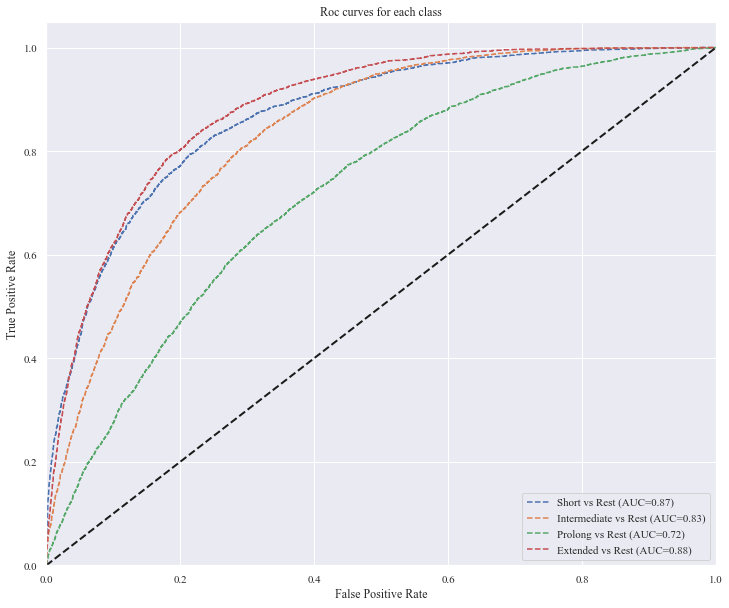

In [169]:
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))
pred_GB = GB.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(classes)
class_names =['Short','Intermediate','Prolong','Extended']
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(8, 6))
#colors = ['blue', 'red', 'green', 'orange', 'purple'] # Define colors for the curves

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_GB[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))


#plt.plot(fpr[i], tpr[i], linestyle='--', 
            #label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curves for each class')
plt.legend(loc="lower right")
plt.show()
